## DBSCAN and Kmeans Models with Centroid Analysis

This notebook includes DBSCAN and Kmeans models for the combined XCO2 and SVI dataset. The models were created based on different augmentations to the dataset, such as using temporal features (total percentage change in CO2), multilevel indexing of the data, and functional data reduction to extract the characteristics of the dataset that may be meaningful such as slope and mean. Centroid analysis was then implemented by computing the means of each variable following clustering to help visualize how the compared across clusters and across each variable .  

## Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Load data
data = pd.read_csv('2014_2020_all_tract.csv')

# Remove negative values for SVI variables
data.drop(data[data['overall_svi'] < 0].index, axis=0, inplace=True)

# Drop duplicate columns
data.drop(['FIPS.1', 'year.1'], axis=1, inplace=True)

# Summary of data
data.describe()

longitude       latitude          FIPS        avg_co2  \
count  481356.000000  481356.000000  4.813560e+05  481356.000000   
mean      -91.338791      37.891423  2.785289e+10     405.293959   
std        15.777743       5.080544  1.581195e+10       5.049527   
min      -167.500000      25.500000  1.001020e+09     395.892359   
25%       -97.500000      34.500000  1.211991e+10     400.472697   
50%       -86.500000      38.500000  2.713908e+10     405.795074   
75%       -79.500000      41.500000  4.103196e+10     409.961034   
max       -67.500000      64.500000  5.604595e+10     414.554260   

                year             ST         STCNTY  total_population  \
count  481356.000000  481356.000000  481356.000000     481356.000000   
mean     2016.881645      27.766719   27852.635862       4300.937201   
std         1.967553      15.788303   15811.944530       2033.852703   
min      2014.000000       1.000000    1001.000000          3.000000   
25%      2015.000000      12.000000   12119.000000       2901.000000   
50%      2017.000000      27.000000   27139.000000       4040.000000   
75%      2019.000000      41.000000   41031.000000       5359.500000   
max      2020.000000      56.000000   56045.000000      70271.000000   

       housing_units  num_households  ...    overall_svi       xco2_std  \
count  481356.000000   481356.000000  ...  481356.000000  481356.000000   
mean     1821.007041     1599.736943  ...       0.504423       2.237366   
std       819.138212      726.822753  ...       0.287549       0.562420   
min         0.000000        0.000000  ...       0.000000       0.906687   
25%      1266.000000     1098.500000  ...       0.256200       1.728153   
50%      1717.000000     1514.000000  ...       0.505900       2.251890   
75%      2249.500000     1994.000000  ...       0.754100       2.727143   
max     26436.000000    21337.000000  ...       1.000000       3.853587   

       co2_1yr_change  co2_6yr_change  co2_1yr_pct_change  co2_6yr_pct_change  \
count   409508.000000    61497.000000       409508.000000        61497.000000   
mean         0.010997        0.146357            0.000203            0.000548   
std          7.592208        7.715505            0.018734            0.019057   
min        -16.194244      -16.096046           -0.039197           -0.039042   
25%         -5.931938       -6.004117           -0.014680           -0.014815   
50%          1.928314        1.819606            0.004833            0.004482   
75%          5.943428        5.799454            0.014863            0.014594   
max         16.137922       16.137922            0.040699            0.040620   

       co2_5yr_pct_change  co2_4yr_pct_change  co2_3yr_pct_change  \
count       122112.000000       193953.000000       265813.000000   
mean             0.000177           -0.000134           -0.000084   
std              0.020154            0.019005            0.019149   
min             -0.039342           -0.039213           -0.039062   
25%             -0.015951           -0.014315           -0.014632   
50%              0.004508           -0.005109           -0.004439   
75%              0.016814            0.014356            0.014554   
max              0.040918            0.040650            0.040814   

       co2_2yr_pct_change  
count       337669.000000  
mean             0.000107  
std              0.018507  
min             -0.039310  
25%             -0.013938  
50%             -0.004226  
75%              0.014229  
max              0.040830  

[8 rows x 25 columns]

The dataset contains the following columns:

In [2]:
data.columns

Index(['longitude', 'latitude', 'FIPS', 'avg_co2', 'year', 'ST', 'STATE',
       'ST_ABBR', 'STCNTY', 'COUNTY', 'LOCATION', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std', 'co2_1yr_change', 'co2_6yr_change', 'co2_1yr_pct_change',
       'co2_6yr_pct_change', 'co2_5yr_pct_change', 'co2_4yr_pct_change',
       'co2_3yr_pct_change', 'co2_2yr_pct_change'],
      dtype='object')

## Functions for the cluster modeling and centroid visualization

In [3]:
# DBSCAN model
def fit_dbscan(df, epsilon, samples):
    dbscan_df = df.copy()
    dbscan = DBSCAN(eps = epsilon, min_samples = samples)
    dbscan.fit(dbscan_df)
    # add cluster labels to df
    dbscan_df['Cluster']=dbscan.labels_
    labels = dbscan.labels_
    n_clusters=len(set(dbscan.labels_)) - (1 if -1 in labels else 0)
    # measure silhouette score
    if n_clusters == 0:
            sil_dbscan_df = 0
    else:    
        sil_dbscan_df = metrics.silhouette_score(dbscan_df, labels)
    return dbscan_df, n_clusters, sil_dbscan_df

# Fit DBSCAN using multiple eps and sample values
def dbscan_test(eps_vals, min_sample_vals, df):

    epsilon = []
    m_samples = []
    sil_scores = []
    n_clusters = []

    for eps in eps_vals:
        for samples in min_sample_vals:
            model_df, cluster_num, sil_score = fit_dbscan(df, eps, samples)
            n_clusters.append(cluster_num)
            sil_scores.append(sil_score)
            epsilon.append(eps)
            m_samples.append(samples)
    
    return epsilon, m_samples, sil_scores, n_clusters, model_df

def centroid_summary(start, end, cluster_labels, init_df):
    
    clusters = ['Cluster {}'.format(i) for i in range(start, end)]
    memb =  pd.Series(cluster_labels, index=init_df.index)
    centroids_sum_mean = pd.DataFrame(0.0, index =  clusters,
                            columns = init_df.columns)
    centroids_sum_median = pd.DataFrame(0.0, index =  clusters,
                            columns = init_df.columns)
    
    for i in range(start, end):
        centroids_sum_mean.iloc[i] = init_df[memb==i].mean(axis=0)
        centroids_sum_median.iloc[i] = init_df[memb==i].median(axis=0)
    
    return centroids_sum_mean, centroids_sum_median

def kmeans_sse(df):
    repetitions = ['R{}'.format(i) for i in range(1,10)]

    SSE_results = pd.DataFrame(0.0, index = range(2,15),
                            columns= repetitions)

    for n_cluster in SSE_results.index:
        for col in SSE_results.columns:
            algort = KMeans(n_clusters=n_cluster).fit(df)
            SSE_results.at[n_cluster,col] = algort.inertia_
            # Inertia: Sum of distances of samples to their closest cluster center

    SSE_results['Mean'] = SSE_results[repetitions].mean(axis=1)
    SSE_results['Var'] = SSE_results[repetitions].var(axis=1)
    
    return SSE_results.sort_values('Mean')

def kmeans_sil_scores(df):
    repetitions = ['R{}'.format(i) for i in range(1,10)]

    SIL_results = pd.DataFrame( index = range(2,15),
                                columns= repetitions)


    for n_cluster in SIL_results.index:
        for col in SIL_results.columns:
            algort = KMeans(n_clusters=n_cluster).fit(df)
            SIL_results.at[n_cluster,col] = metrics.silhouette_score(df,algort.labels_)

    SIL_results['Mean'] = SIL_results[repetitions].mean(axis=1)
    SIL_results['Var'] = SIL_results[repetitions].var(axis=1)
    
    return SIL_results.sort_values('Mean',ascending=False)

def silhouette_score(df, labels):
    df_copy = df.copy()
    df_copy['Cluster'] = labels
    sil_score = metrics.silhouette_score(df_copy,labels)
    return sil_score, df_copy['Cluster'].value_counts()

## Model using total percentage change in CO2 values

To examine the temporal features, we subset the dataset including the 'co2_6yr_pct_change' column which represents the total percentage change in CO2 values across the time period.

In [4]:
# Subset dataset

df_tot_pct_change = data[['avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std', 'co2_6yr_pct_change']]

# Drop NaN values 
df_tot_pct_change = df_tot_pct_change.dropna(axis=0)

# Check shape of the df
df_tot_pct_change.shape

(61497, 12)

In [5]:
# Scaling the data
# initialize scaler
scaler = StandardScaler()

scaled_df_tot_pct_change = df_tot_pct_change.copy()

# scale the data
scaled_df_tot_pct_change  = pd.DataFrame(scaler.fit_transform(scaled_df_tot_pct_change))

# rename columns
scaled_df_tot_pct_change.columns = df_tot_pct_change.columns

### DBSCAN using total percentage change in CO2 values

In [6]:
eps = np.linspace(1.0, 2.0, 5)
min_samples = list(range(5,11))
tot_pct_eps, tot_pct_samples, tot_pct_sil, tot_pct_n_clusters, tot_pct_dbscan_df = dbscan_test(eps, min_samples, scaled_df_tot_pct_change)

In [7]:
dbscan_tot_pct_change = pd.DataFrame(data={'Epsilon': tot_pct_eps, 'Min_samples': tot_pct_samples, 'Silhouette Scores': tot_pct_sil, 'Num of Clusters': tot_pct_n_clusters})

# Epsilon, Min_samples at max silhouette score
dbscan_tot_pct_change.loc[dbscan_tot_pct_change['Silhouette Scores'].idxmax()]

Epsilon              2.000000
Min_samples          6.000000
Silhouette Scores    0.411602
Num of Clusters      1.000000
Name: 25, dtype: float64

Print the results of the different DBSCAN models

In [8]:
print(dbscan_tot_pct_change.to_string())

    Epsilon  Min_samples  Silhouette Scores  Num of Clusters
0      1.00            5          -0.108862              202
1      1.00            6          -0.096074              134
2      1.00            7          -0.081880              120
3      1.00            8          -0.016394              114
4      1.00            9          -0.056284               89
5      1.00           10          -0.067165               75
6      1.25            5          -0.062796               32
7      1.25            6           0.040090               17
8      1.25            7           0.075086               16
9      1.25            8           0.073616               14
10     1.25            9           0.071613               10
11     1.25           10           0.053101               10
12     1.50            5           0.096167               10
13     1.50            6           0.158016                7
14     1.50            7           0.156862                8
15     1.50            8

Filter to see the results where the model resulted in clusters > 2 and < 10 to help select the one that could be used to interpret results of clustering. 

In [9]:
dbscan_tot_pct_change[(dbscan_tot_pct_change['Num of Clusters'] > 2) & (dbscan_tot_pct_change['Num of Clusters'] < 10)]

Epsilon  Min_samples  Silhouette Scores  Num of Clusters
13     1.50            6           0.158016                7
14     1.50            7           0.156862                8
15     1.50            8           0.154144                5
16     1.50            9           0.153782                5
17     1.50           10           0.153503                5
18     1.75            5           0.348076                3
19     1.75            6           0.133995                4
24     2.00            5           0.208963                4

Refit DBSCAN models using epsilon = 1.75, min_sample = 5 and epsilon = 2.00, min_sample = 5

In [10]:
dbscan_tot_pct_change_fin_1, tot_pct_change_cluster_num_1, tot_pct_change_sil_score_1 = fit_dbscan(scaled_df_tot_pct_change, 1.75, 5)
dbscan_tot_pct_change_fin_2, tot_pct_change_cluster_num_2, tot_pct_change_sil_score_2 = fit_dbscan(scaled_df_tot_pct_change, 2.00, 5)

In [11]:
dbscan_tot_pct_change_fin_1['Cluster'].value_counts()

 0    60941
-1      488
 1       64
 2        4
Name: Cluster, dtype: int64

In [12]:
dbscan_tot_pct_change_fin_2['Cluster'].value_counts()

 0    61264
-1      220
 1        5
 2        4
 3        4
Name: Cluster, dtype: int64

Centroid analyses of DBSCAN using temporal features

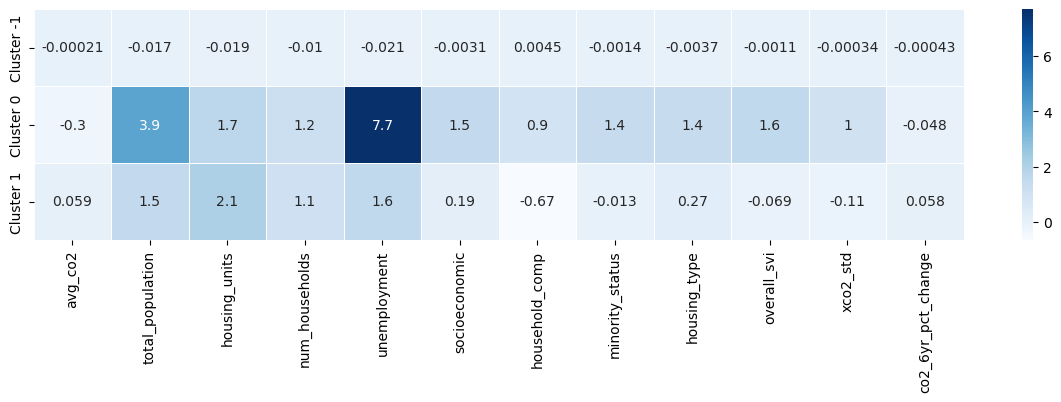

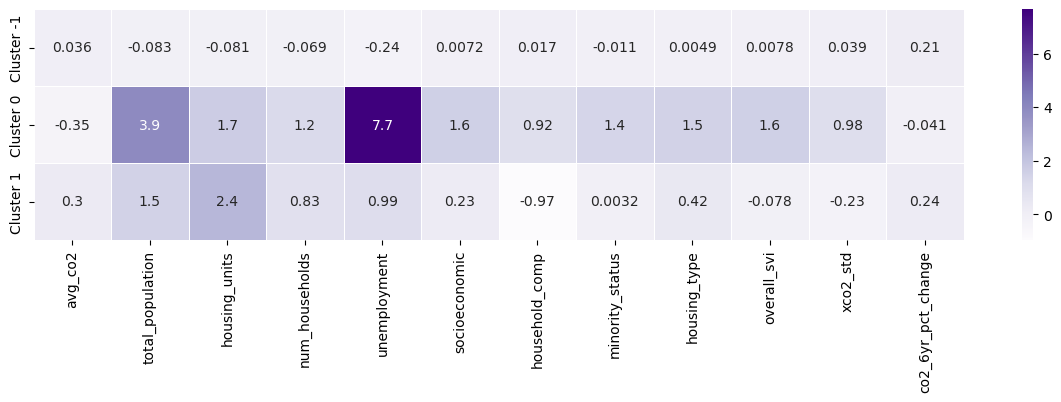

In [13]:
import seaborn as sns
tot_pct_change_centroid_sum_mean_1, tot_pct_change_centroid_sum_median_1 = centroid_summary(-1, 2, dbscan_tot_pct_change_fin_1['Cluster'], scaled_df_tot_pct_change)

plt.figure(figsize=(15,3))
sns.heatmap(tot_pct_change_centroid_sum_mean_1, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(15,3))
sns.heatmap(tot_pct_change_centroid_sum_median_1, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

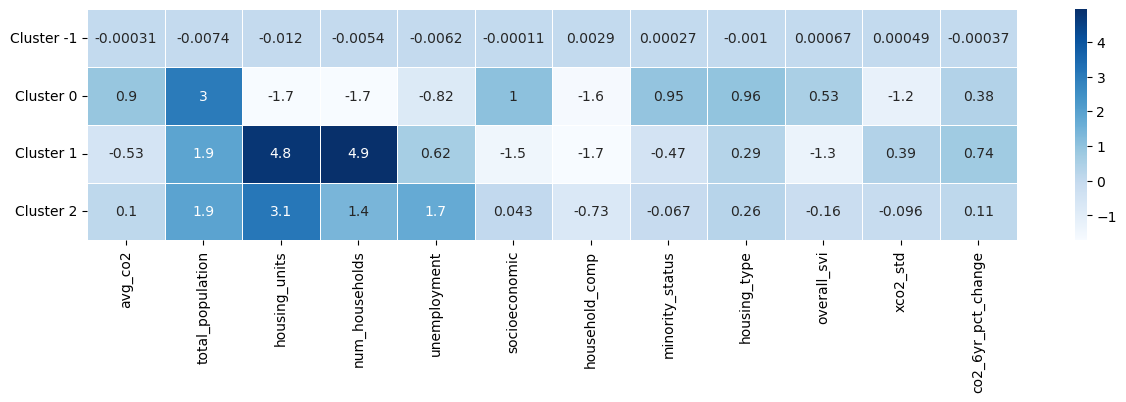

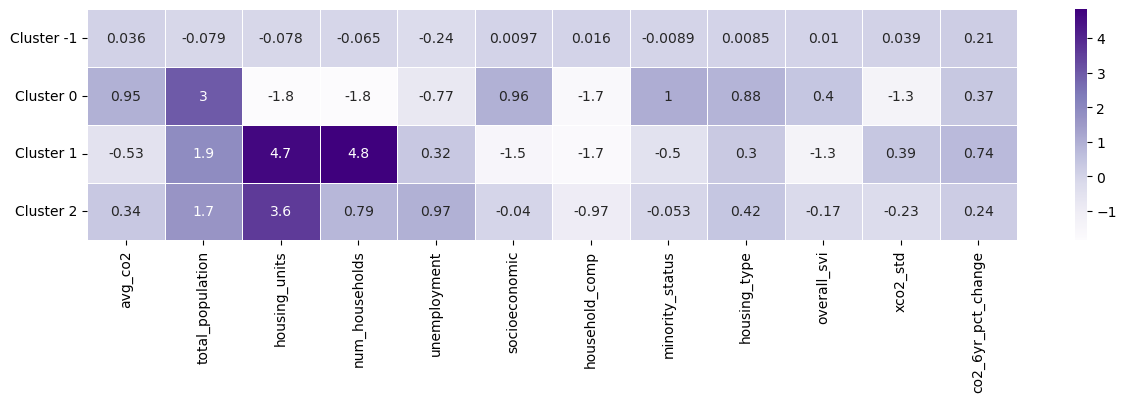

In [14]:
tot_pct_change_centroid_sum_mean_2, tot_pct_change_centroid_sum_median_2 = centroid_summary(-1, 3, dbscan_tot_pct_change_fin_2['Cluster'], scaled_df_tot_pct_change)

plt.figure(figsize=(15,3))
sns.heatmap(tot_pct_change_centroid_sum_mean_2, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(15,3))
sns.heatmap(tot_pct_change_centroid_sum_median_2, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

### Kmeans using using total percentage change in CO2 values

In [15]:
# Sample of dataset to run SSE and silhouette score to select kmeans num of clusters
tot_pct_change_sample = scaled_df_tot_pct_change.sample(30000)

/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

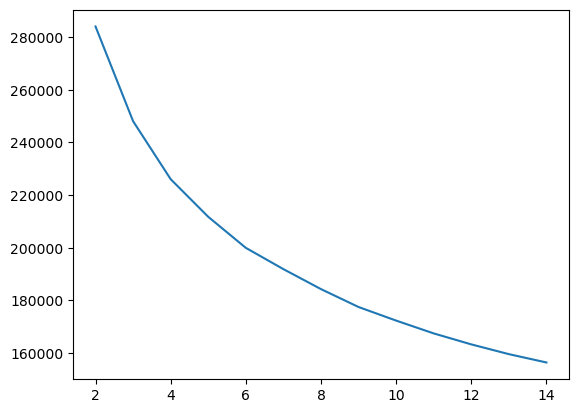

In [16]:
sse_tot_pct_results = kmeans_sse(tot_pct_change_sample)
(sse_tot_pct_results.Mean).plot()
plt.show()

/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

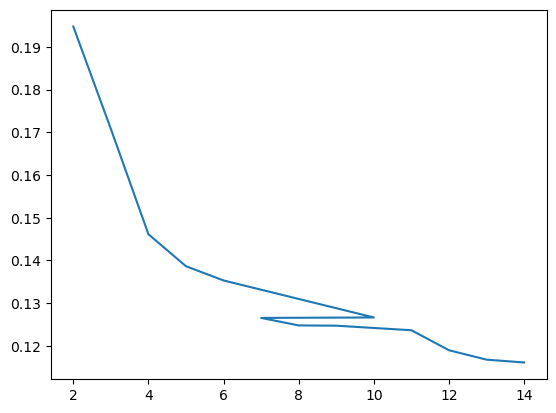

In [17]:
sil_tot_pct_results = kmeans_sil_scores(tot_pct_change_sample)
(sil_tot_pct_results.Mean).plot()
plt.show()

In [18]:
# Fit kmeans model for n_clusters = 4, n_clusters = 5, n_clusters = 6 on full dataset
kmeans_tot_pct_1 = KMeans(n_clusters=4).fit(scaled_df_tot_pct_change)
kmeans_tot_pct_2 = KMeans(n_clusters=5).fit(scaled_df_tot_pct_change)
kmeans_tot_pct_3 = KMeans(n_clusters=6).fit(scaled_df_tot_pct_change)

/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
# Calculate silhouette score of each model
kmeans_tot_pct_sil1, kmeans_tot_pct_clust_cnt_1 = silhouette_score(scaled_df_tot_pct_change, kmeans_tot_pct_1.labels_)
print('Silhouette score of kmeans model with n_clusters = 4: ' + str(kmeans_tot_pct_sil1))

kmeans_tot_pct_sil2, kmeans_tot_pct_clust_cnt_2 = silhouette_score(scaled_df_tot_pct_change, kmeans_tot_pct_2.labels_)
print('Silhouette score of kmeans model with n_clusters = 5: ' + str(kmeans_tot_pct_sil2))

kmeans_tot_pct_sil3, kmeans_tot_pct_clust_cnt_3 = silhouette_score(scaled_df_tot_pct_change, kmeans_tot_pct_3.labels_)
print('Silhouette score of kmeans model with n_clusters = 6: ' + str(kmeans_tot_pct_sil3))

Silhouette score of kmeans model with n_clusters = 4: 0.21512731061569312
Silhouette score of kmeans model with n_clusters = 5: 0.2230574650987509
Silhouette score of kmeans model with n_clusters = 6: 0.2061228566861595


In [20]:
# Count of points assigned to each cluster

# Kmeans, n_cluster = 4
kmeans_tot_pct_clust_cnt_1

1    17698
2    17462
0    14648
3    11689
Name: Cluster, dtype: int64

In [21]:
# Kmeans, n_cluster = 5
kmeans_tot_pct_clust_cnt_2

2    15884
4    12498
0    11785
3    10678
1    10652
Name: Cluster, dtype: int64

In [22]:
# Kmeans, n_cluster = 6
kmeans_tot_pct_clust_cnt_3

1    11952
4    11615
2    10286
5    10080
0     9585
3     7979
Name: Cluster, dtype: int64

Centroid analyses of kmeans using temporal features

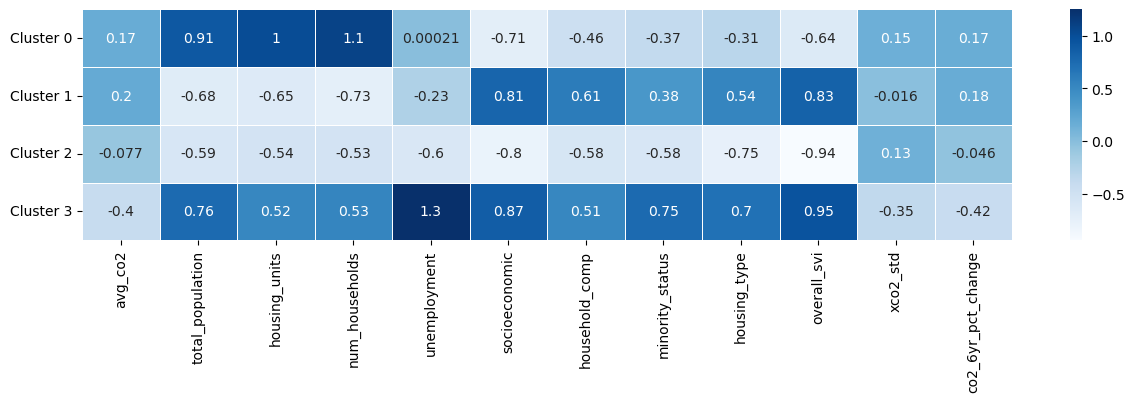

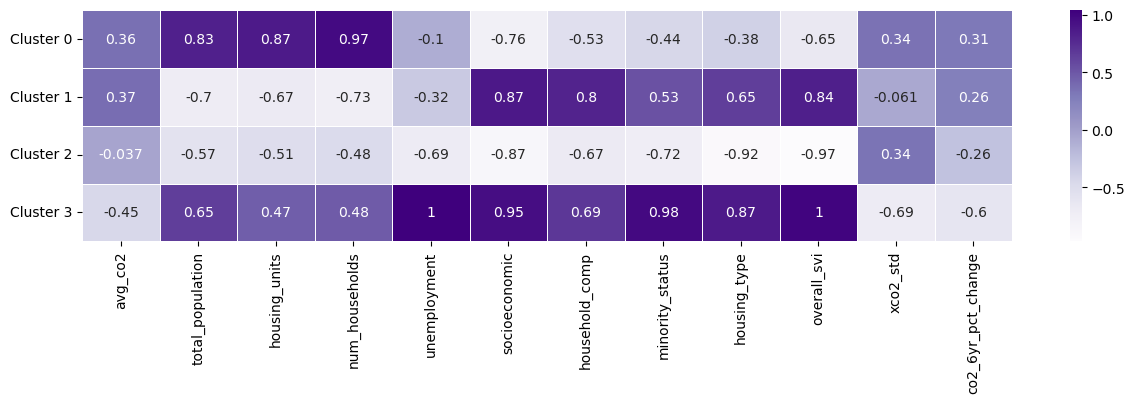

In [23]:
kmeans_tot_pct_centroid_sum_mean_1, kmeans_tot_pct_centroid_sum_median_1 = centroid_summary(0, 4, kmeans_tot_pct_1.labels_, scaled_df_tot_pct_change)

plt.figure(figsize=(15,3))
sns.heatmap(kmeans_tot_pct_centroid_sum_mean_1, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(15,3))
sns.heatmap(kmeans_tot_pct_centroid_sum_median_1, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

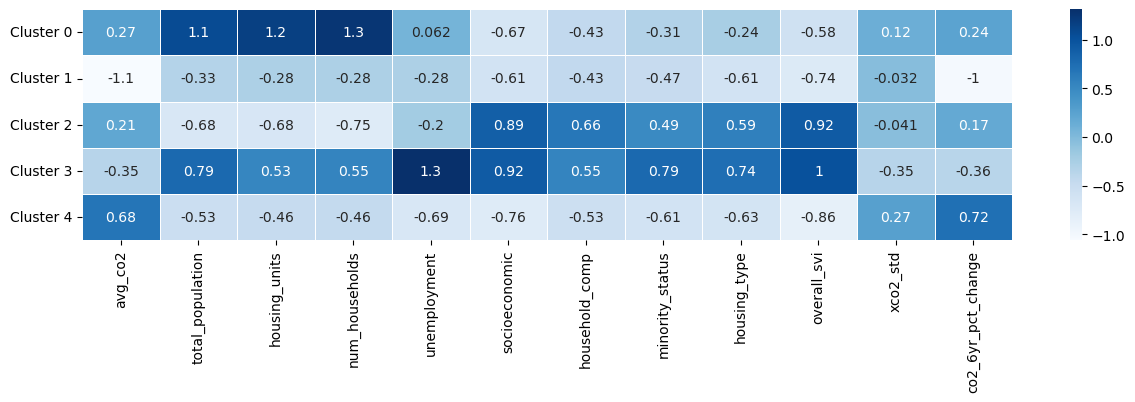

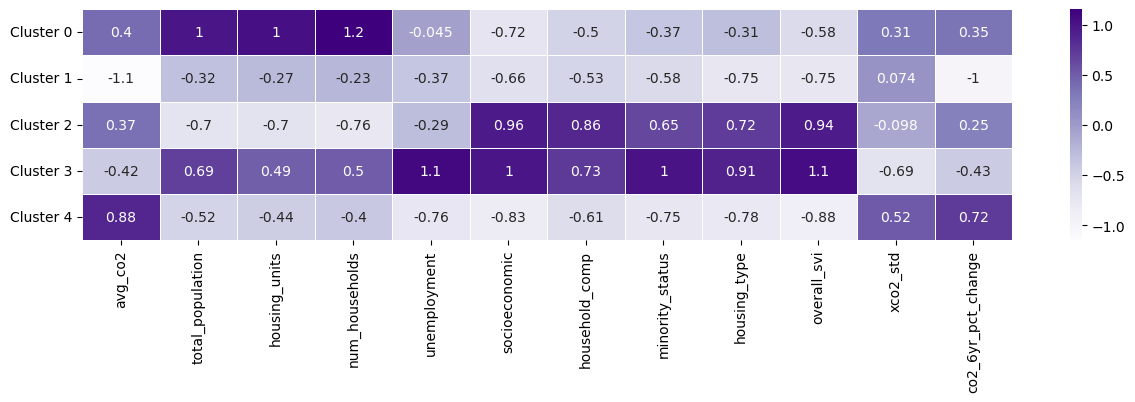

In [24]:
kmeans_tot_pct_centroid_sum_mean_2, kmeans_tot_pct_centroid_sum_median_2 = centroid_summary(0, 5, kmeans_tot_pct_2.labels_, scaled_df_tot_pct_change)

plt.figure(figsize=(15,3))
sns.heatmap(kmeans_tot_pct_centroid_sum_mean_2, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(15,3))
sns.heatmap(kmeans_tot_pct_centroid_sum_median_2, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

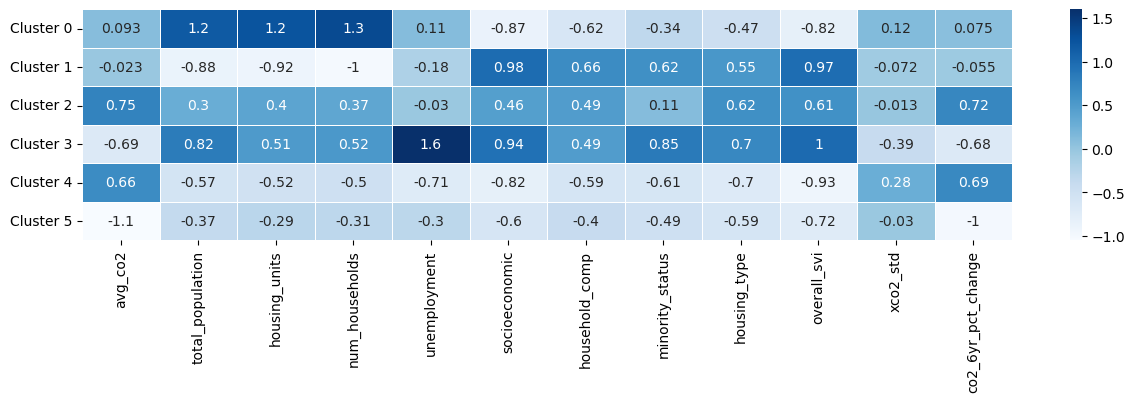

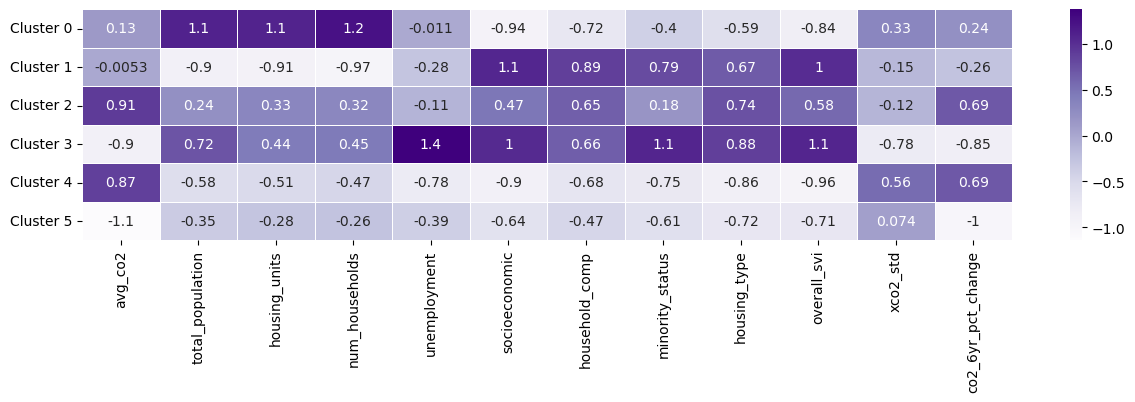

In [25]:
kmeans_tot_pct_centroid_sum_mean_3, kmeans_tot_pct_centroid_sum_median_3 = centroid_summary(0, 6, kmeans_tot_pct_3.labels_, scaled_df_tot_pct_change)

plt.figure(figsize=(15,3))
sns.heatmap(kmeans_tot_pct_centroid_sum_mean_3, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(15,3))
sns.heatmap(kmeans_tot_pct_centroid_sum_median_3, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

## Multilevel indexing for all years of data

Instead of using temporal change features such as % change in CO2, here the dataset is reorganized using multilevel indexing on FIPS and year fields.

In [26]:
# Subset and scale the data
# initialize scaler
scaler = StandardScaler()

scaled_df_subset = data[['FIPS','avg_co2', 'xco2_std', 'year','total_population', 'housing_units', 'num_households', 'unemployment','socioeconomic', 'household_comp', 'minority_status', 'housing_type']].copy()


# scale the data
scaled_df_subset[['avg_co2', 'xco2_std','total_population', 'housing_units', 'num_households', 'unemployment','socioeconomic', 'household_comp', 'minority_status', 'housing_type']] = scaler.fit_transform(scaled_df_subset[['avg_co2', 'xco2_std','total_population', 'housing_units', 'num_households', 'unemployment','socioeconomic', 'household_comp', 'minority_status', 'housing_type']])

# Start by pivoting data
pivoted_df = scaled_df_subset[['FIPS','avg_co2', 'xco2_std', 'year','total_population', 'housing_units', 'num_households', 'unemployment','socioeconomic', 'household_comp', 'minority_status', 'housing_type']].pivot_table(index='FIPS', columns='year')

pivoted_df.dropna(axis=0, inplace=True)

pivoted_df.head()


avg_co2                                                            \
year           2014      2015      2016     2017      2018      2019     2020   
FIPS                                                                            
1001020100 -1.54482 -1.000387 -0.360496  0.02608  0.462927  1.011611  1.52262   
1001020200 -1.54482 -1.000387 -0.360496  0.02608  0.462927  1.011611  1.52262   
1001020300 -1.54482 -1.000387 -0.360496  0.02608  0.462927  1.011611  1.52262   
1001020400 -1.54482 -1.000387 -0.360496  0.02608  0.462927  1.011611  1.52262   
1001020600 -1.54482 -1.000387 -0.360496  0.02608  0.462927  1.011611  1.52262   

           household_comp                      ... unemployment            \
year                 2014      2015      2016  ...         2018      2019   
FIPS                                           ...                          
1001020100      -0.587399 -0.773455 -0.959510  ...    -1.031834 -1.106653   
1001020200      -0.575693 -0.078008  0.419677  ...    -1.031834 -1.058241   
1001020300       1.301534  0.972522  0.643511  ...    -0.855787 -0.864589   
1001020400       1.047548  1.054820  1.062092  ...    -0.908601 -0.952613   
1001020600       1.103240  0.730065  0.356890  ...    -0.371660 -0.706148   

                      xco2_std                                          \
year            2020      2014      2015      2016      2017      2018   
FIPS                                                                     
1001020100 -1.181473 -0.313313 -0.408688 -1.850916 -0.025444 -0.158256   
1001020200 -1.084647 -0.313313 -0.408688 -1.850916 -0.025444 -0.158256   
1001020300 -0.873392 -0.313313 -0.408688 -1.850916 -0.025444 -0.158256   
1001020400 -0.996624 -0.313313 -0.408688 -1.850916 -0.025444 -0.158256   
1001020600 -1.040636 -0.313313 -0.408688 -1.850916 -0.025444 -0.158256   

                                
year            2019      2020  
FIPS                            
1001020100 -0.999227 -0.857332  
1001020200 -0.999227 -0.857332  
1001020300 -0.999227 -0.857332  
1001020400 -0.999227 -0.857332  
1001020600 -0.999227 -0.857332  

[5 rows x 70 columns]

### DBSCAN using multilevel indexed data

In [27]:
eps = np.linspace(1, 2.0, 5)
min_samples = list(range(5,11))
pivot_eps, pivot_samples, pivot_sil, pivot_n_clusters, pivot_dbscan_df = dbscan_test(eps, min_samples, pivoted_df)

In [28]:
dbscan_pivoted = pd.DataFrame(data={'Epsilon': pivot_eps, 'Min_samples': pivot_samples, 'Silhouette Scores': pivot_sil, 'Num of Clusters': pivot_n_clusters})

# Epsilon, Min_samples at max silhouette score
dbscan_pivoted.loc[dbscan_pivoted['Silhouette Scores'].idxmax()]

Epsilon              1.500000
Min_samples          7.000000
Silhouette Scores    0.089811
Num of Clusters      1.000000
Name: 14, dtype: float64

In [29]:
print(dbscan_pivoted.to_string())

    Epsilon  Min_samples  Silhouette Scores  Num of Clusters
0      1.00            5           0.000000                0
1      1.00            6           0.000000                0
2      1.00            7           0.000000                0
3      1.00            8           0.000000                0
4      1.00            9           0.000000                0
5      1.00           10           0.000000                0
6      1.25            5           0.000000                0
7      1.25            6           0.000000                0
8      1.25            7           0.000000                0
9      1.25            8           0.000000                0
10     1.25            9           0.000000                0
11     1.25           10           0.000000                0
12     1.50            5          -0.162448                6
13     1.50            6          -0.022706                2
14     1.50            7           0.089811                1
15     1.50            8

Filter to see the results where the model resulted in clusters > 2 and < 10 to help select the one that could be used to interpret results of clustering. 

In [30]:
dbscan_pivoted[(dbscan_pivoted['Num of Clusters'] > 2) & (dbscan_pivoted['Num of Clusters'] < 10)]

Epsilon  Min_samples  Silhouette Scores  Num of Clusters
12     1.50            5          -0.162448                6
22     1.75            9          -0.150642                8
23     1.75           10          -0.155076                9

Refit DBSCAN models using epsilon = 1.50, min_sample = 5 and epsilon = 1.75, min_sample = 9

In [31]:
dbscan_pivot_fin_1, pivot_cluster_num_1, pivot_sil_score_1 = fit_dbscan(pivoted_df, 1.50, 5)
dbscan_pivot_fin_2, pivot_cluster_num_2, pivot_sil_score_2 = fit_dbscan(pivoted_df, 1.75, 9)

In [32]:
dbscan_pivot_fin_1['Cluster'].value_counts()

-1    60494
 1       12
 2        6
 0        5
 4        5
 5        5
 3        5
Name: Cluster, dtype: int64

In [33]:
dbscan_pivot_fin_2['Cluster'].value_counts()

-1    60248
 1      153
 2       45
 0       23
 4       19
 5       14
 7       11
 3       11
 6        8
Name: Cluster, dtype: int64

Centroid analyses of DBSCAN using multilevel indexing

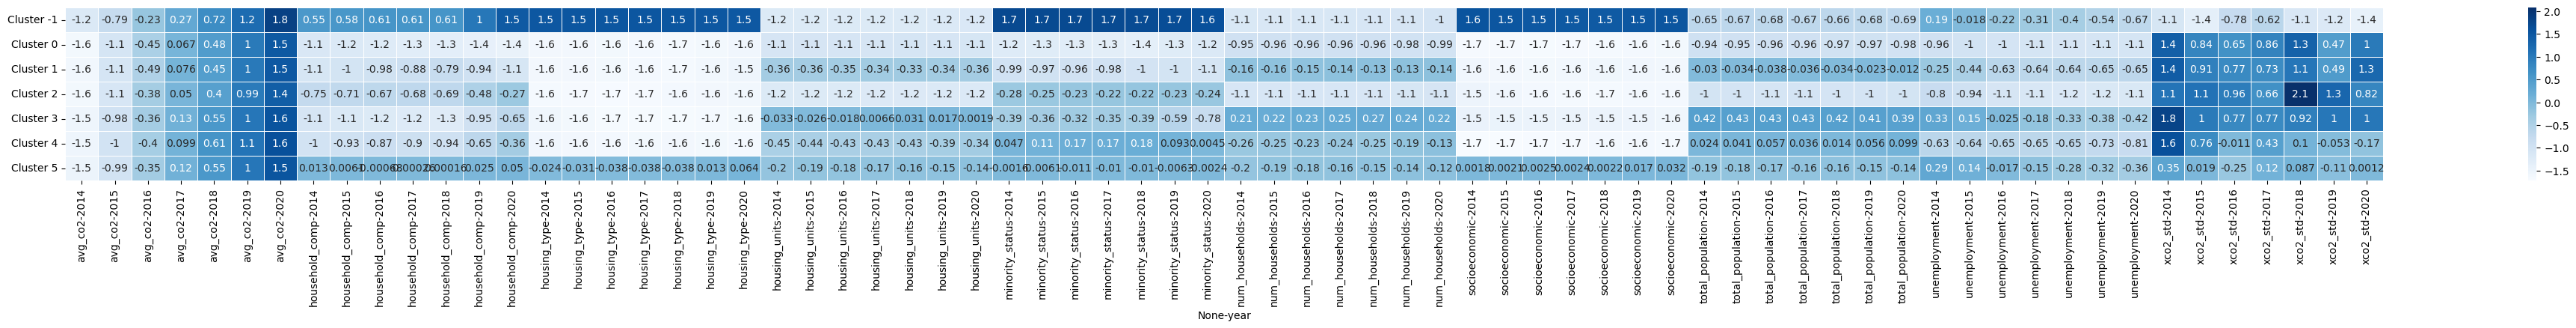

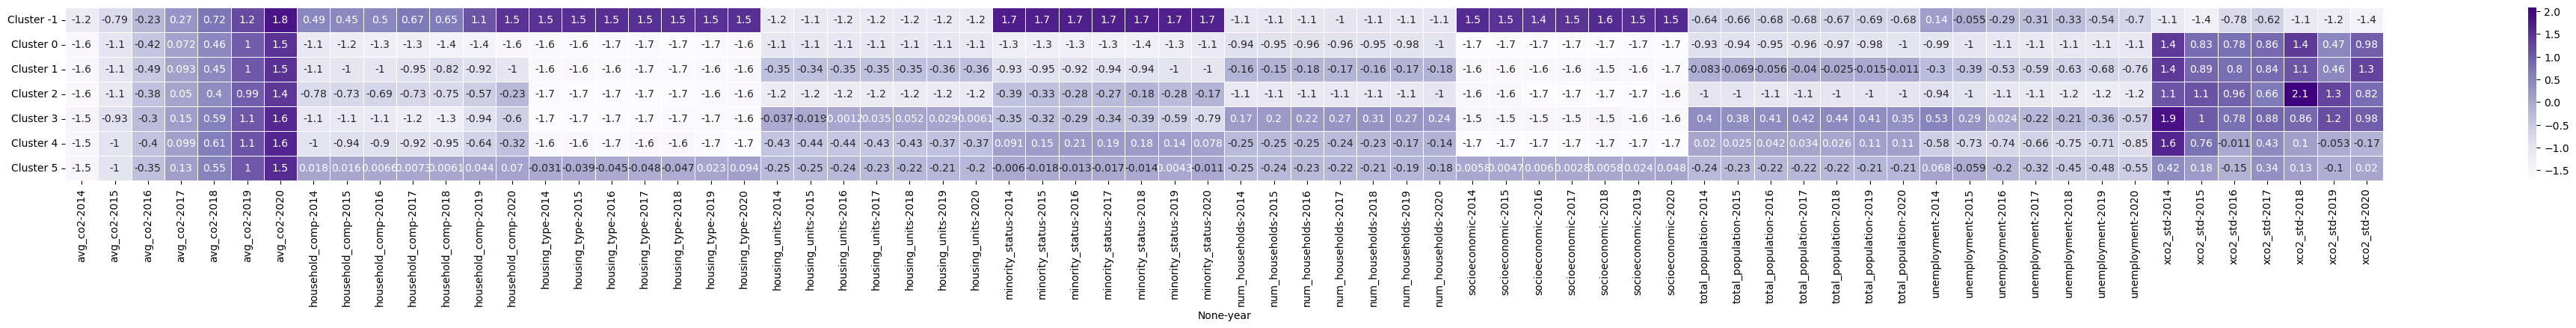

In [34]:
pivot_dbscan_centroid_sum_mean_1, pivot_dbscan_centroid_sum_median_1 = centroid_summary(-1, 6, dbscan_pivot_fin_1['Cluster'], pivoted_df)

plt.figure(figsize=(50,3))
sns.heatmap(pivot_dbscan_centroid_sum_mean_1, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(50,3))
sns.heatmap(pivot_dbscan_centroid_sum_median_1, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

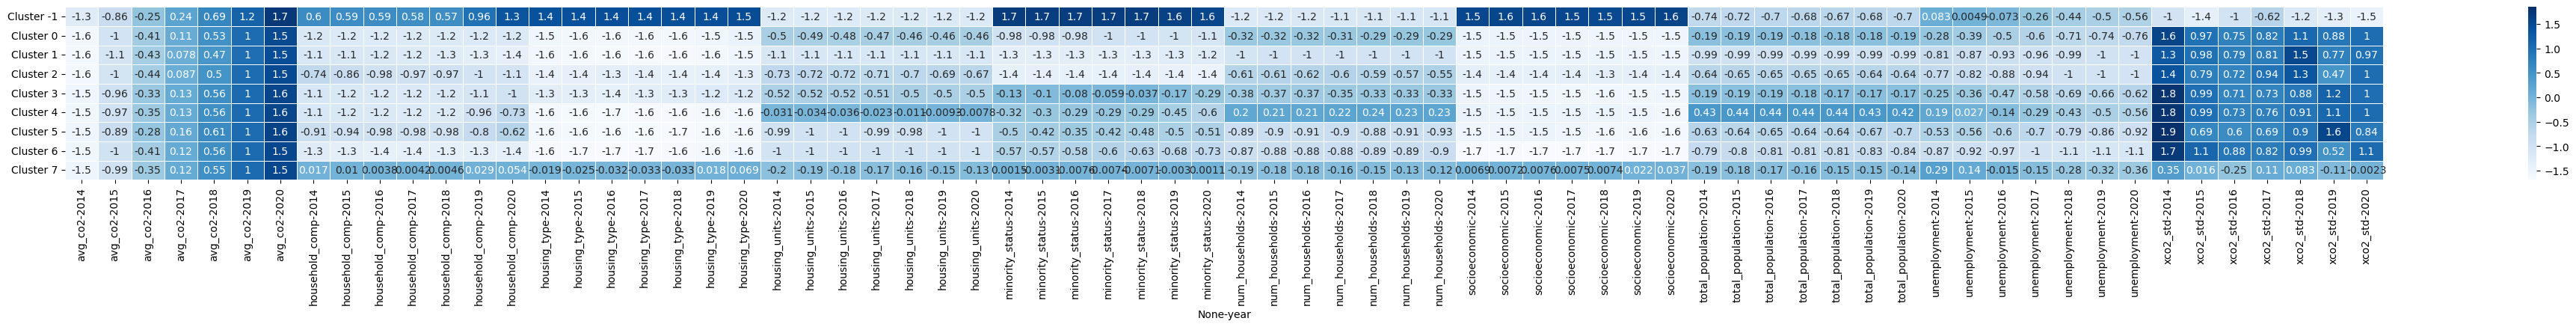

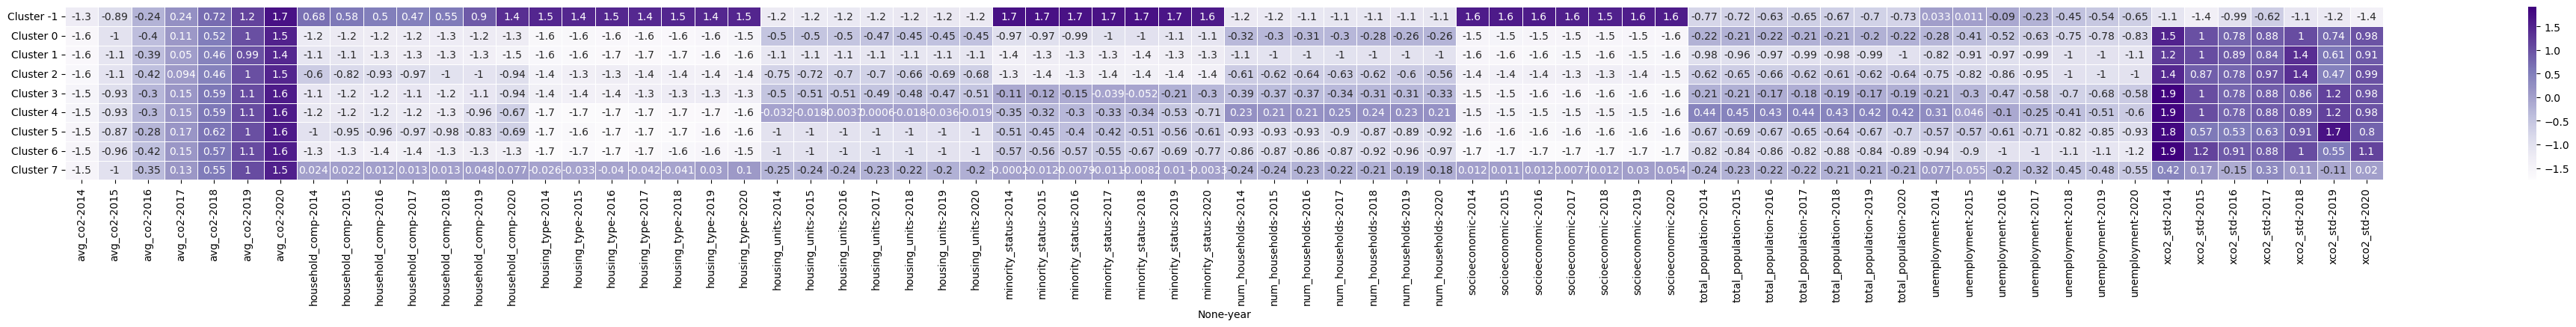

In [35]:
pivot_dbscan_centroid_sum_mean_2, pivot_dbscan_centroid_sum_median_2 = centroid_summary(-1, 8, dbscan_pivot_fin_2['Cluster'], pivoted_df)

plt.figure(figsize=(50,3))
sns.heatmap(pivot_dbscan_centroid_sum_mean_2, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(50,3))
sns.heatmap(pivot_dbscan_centroid_sum_median_2, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

### Kmeans with multilevel indexing

In [36]:
# Sample of dataset to run SSE and silhouette score to select kmeans num of clusters
pivoted_df_sample = pivoted_df.sample(30000)

/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

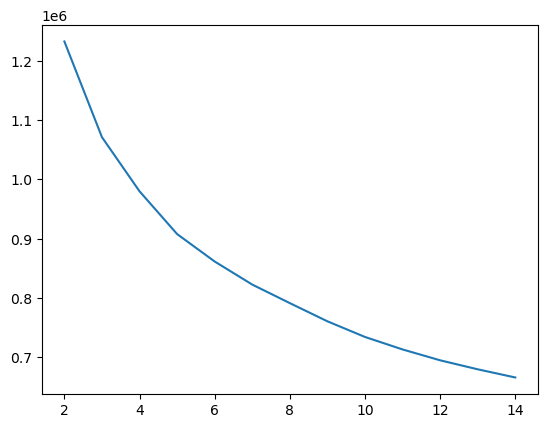

In [37]:
sse_pivot_results = kmeans_sse(pivoted_df_sample)
(sse_pivot_results.Mean).plot()
plt.show()

/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

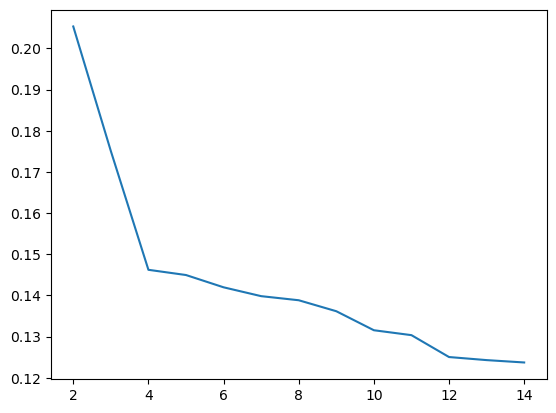

In [38]:
sil_pivot_results = kmeans_sil_scores(pivoted_df_sample)
(sil_pivot_results.Mean).plot()
plt.show()

In [39]:
# Fit kmeans model for n_clusters = 4, n_clusters = 5, n_clusters = 6 on full dataset
kmeans_pivot_1 = KMeans(n_clusters=4).fit(pivoted_df)
kmeans_pivot_2 = KMeans(n_clusters=5).fit(pivoted_df)
kmeans_pivot_3 = KMeans(n_clusters=6).fit(pivoted_df)

/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [40]:
# Calculate silhouette score of each model
kmeans_pivot_sil1, kmeans_pivot_clust_cnt_1 = silhouette_score(pivoted_df, kmeans_pivot_1.labels_)
print('Silhouette score of kmeans model with n_clusters = 4: ' + str(kmeans_pivot_sil1))

kmeans_pivot_sil2, kmeans_pivot_clust_cnt_2 = silhouette_score(pivoted_df, kmeans_pivot_2.labels_)
print('Silhouette score of kmeans model with n_clusters = 5: ' + str(kmeans_pivot_sil2))

kmeans_pivot_sil3, kmeans_pivot_clust_cnt_3 = silhouette_score(pivoted_df, kmeans_pivot_3.labels_)
print('Silhouette score of kmeans model with n_clusters = 6: ' + str(kmeans_pivot_sil3))

Silhouette score of kmeans model with n_clusters = 4: 0.15767802138995138
Silhouette score of kmeans model with n_clusters = 5: 0.16802415969128934
Silhouette score of kmeans model with n_clusters = 6: 0.18153553320930169


In [41]:
# Count of points assigned to each cluster

# Kmeans, n_cluster = 4
kmeans_pivot_clust_cnt_1

1    16927
3    16596
0    15060
2    11949
Name: Cluster, dtype: int64

In [42]:
# Kmeans, n_cluster = 5
kmeans_pivot_clust_cnt_2

2    13761
3    12681
1    12108
4    11545
0    10437
Name: Cluster, dtype: int64

In [43]:
# Kmeans, n_cluster = 6
kmeans_pivot_clust_cnt_3

1    11470
3    10411
5    10360
2    10017
4     9971
0     8303
Name: Cluster, dtype: int64

Centroid analyses of Kmeans using multilevel indexing

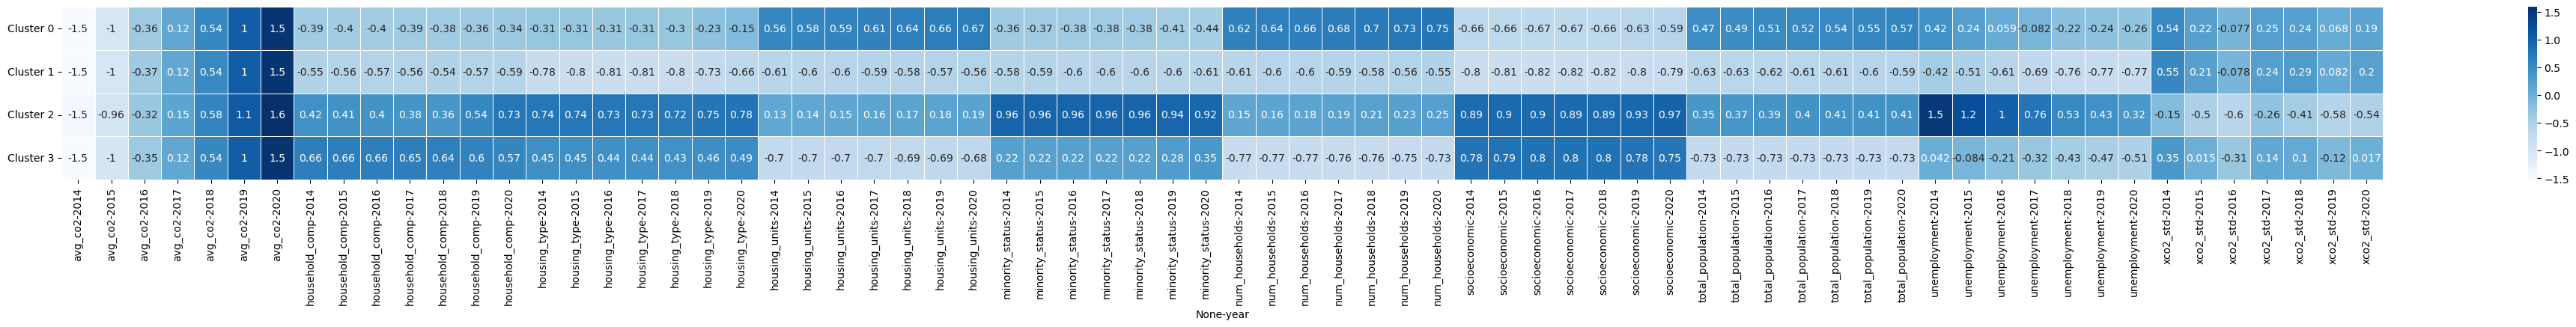

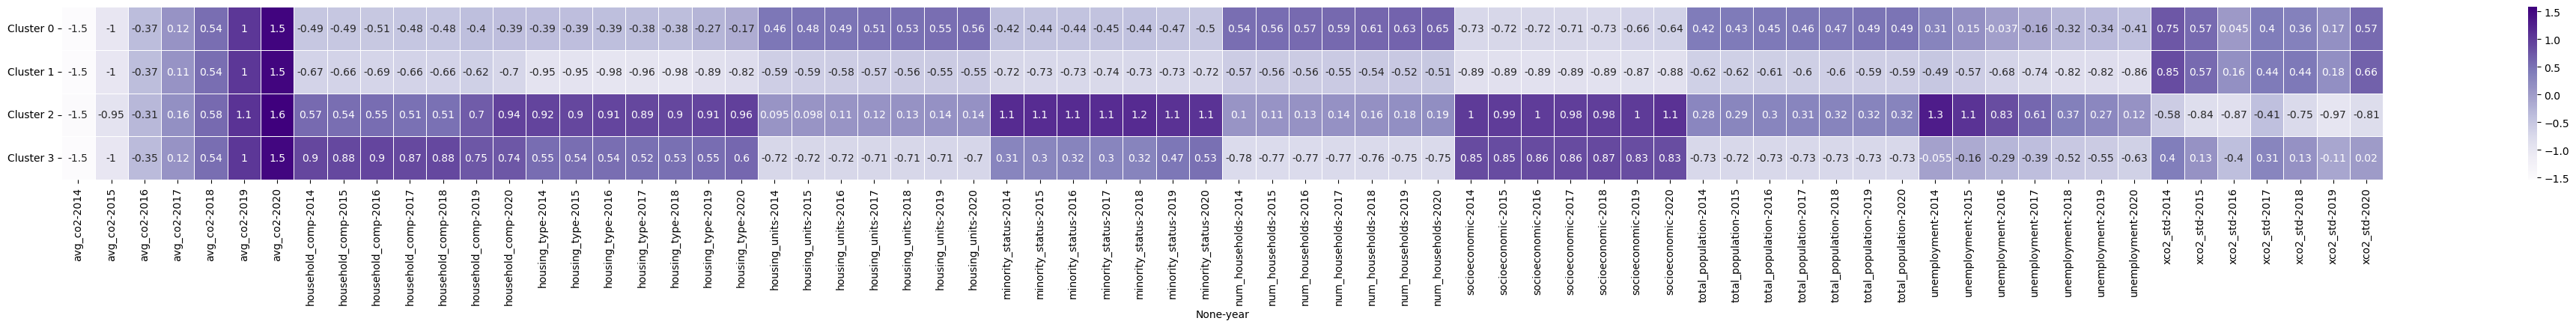

In [44]:
kmeans_pivot_centroid_sum_mean_1, kmeans_pivot_centroid_sum_median_1 = centroid_summary(0, 4, kmeans_pivot_1.labels_, pivoted_df)

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_pivot_centroid_sum_mean_1, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_pivot_centroid_sum_median_1, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

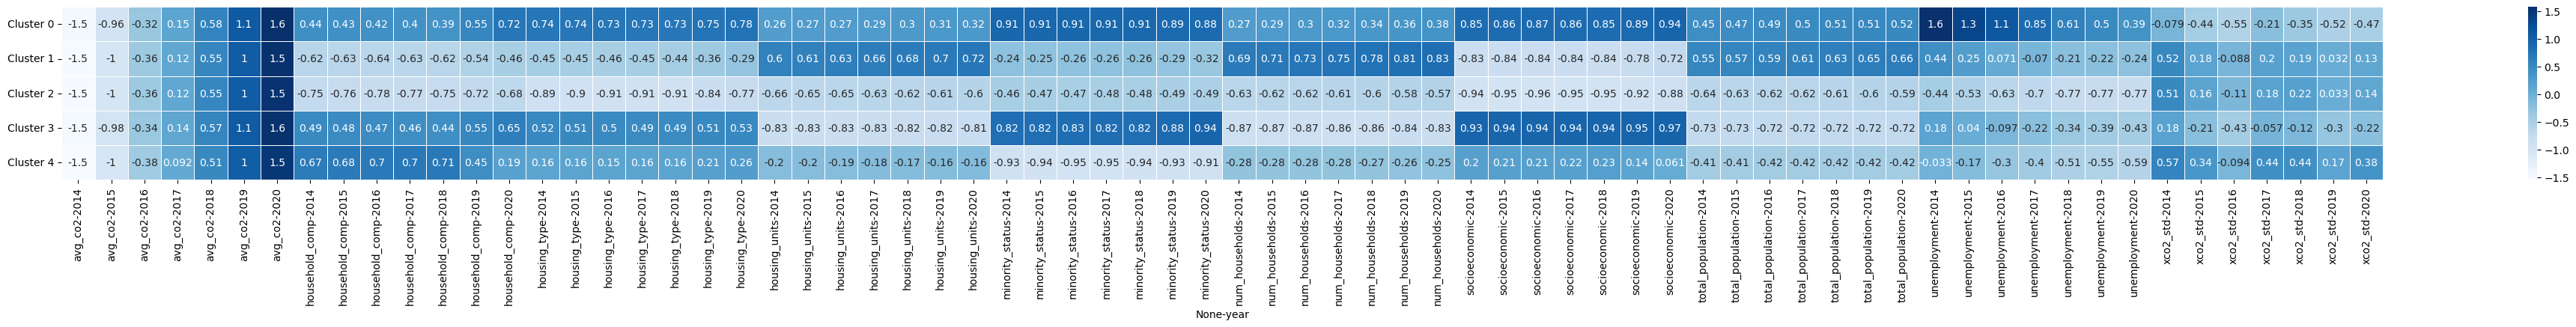

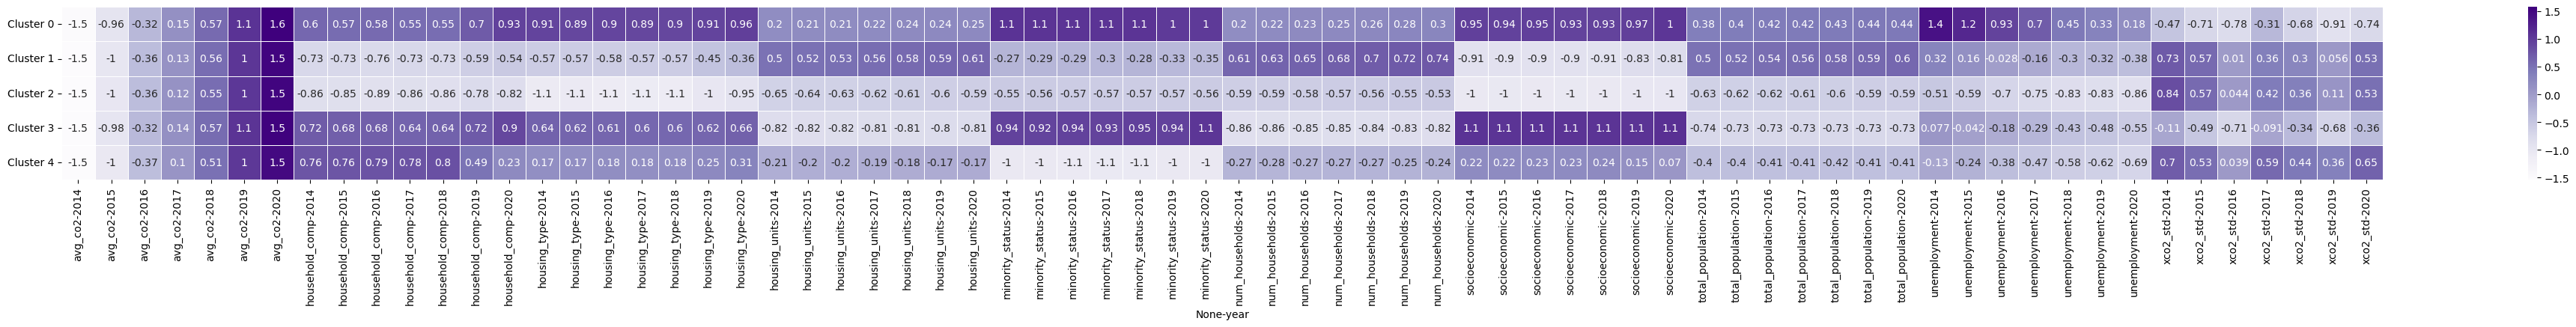

In [45]:
kmeans_pivot_centroid_sum_mean_2, kmeans_pivot_centroid_sum_median_2 = centroid_summary(0, 5, kmeans_pivot_2.labels_, pivoted_df)

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_pivot_centroid_sum_mean_2, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_pivot_centroid_sum_median_2, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

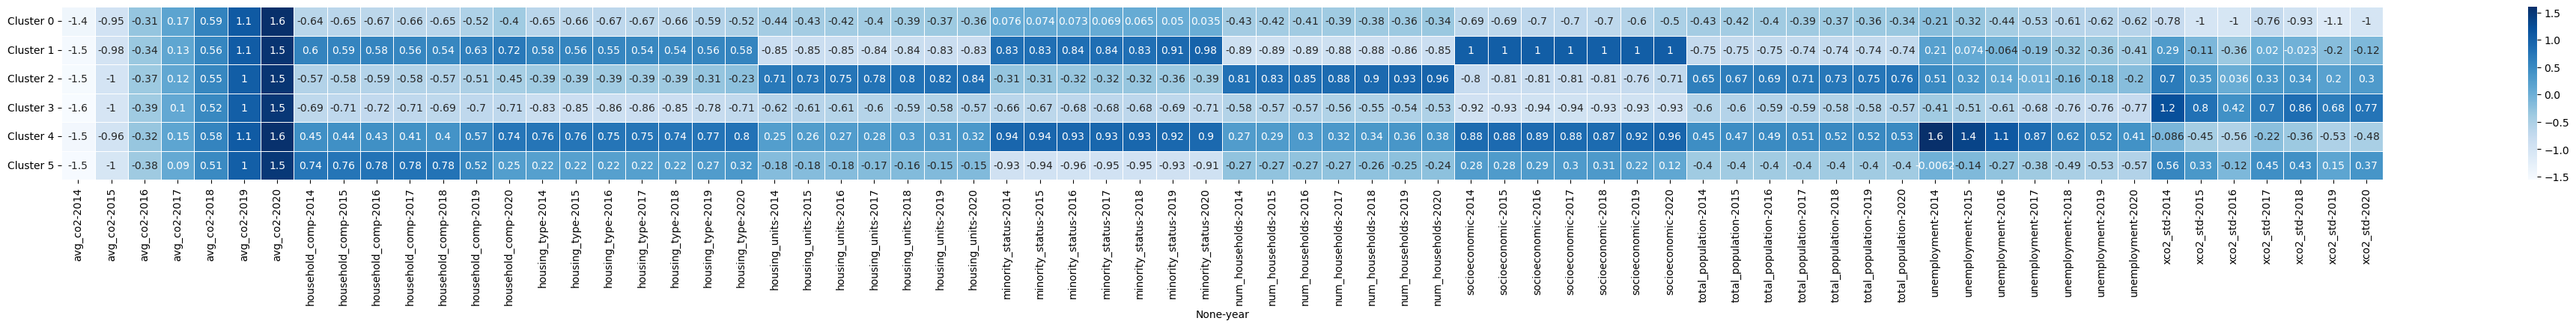

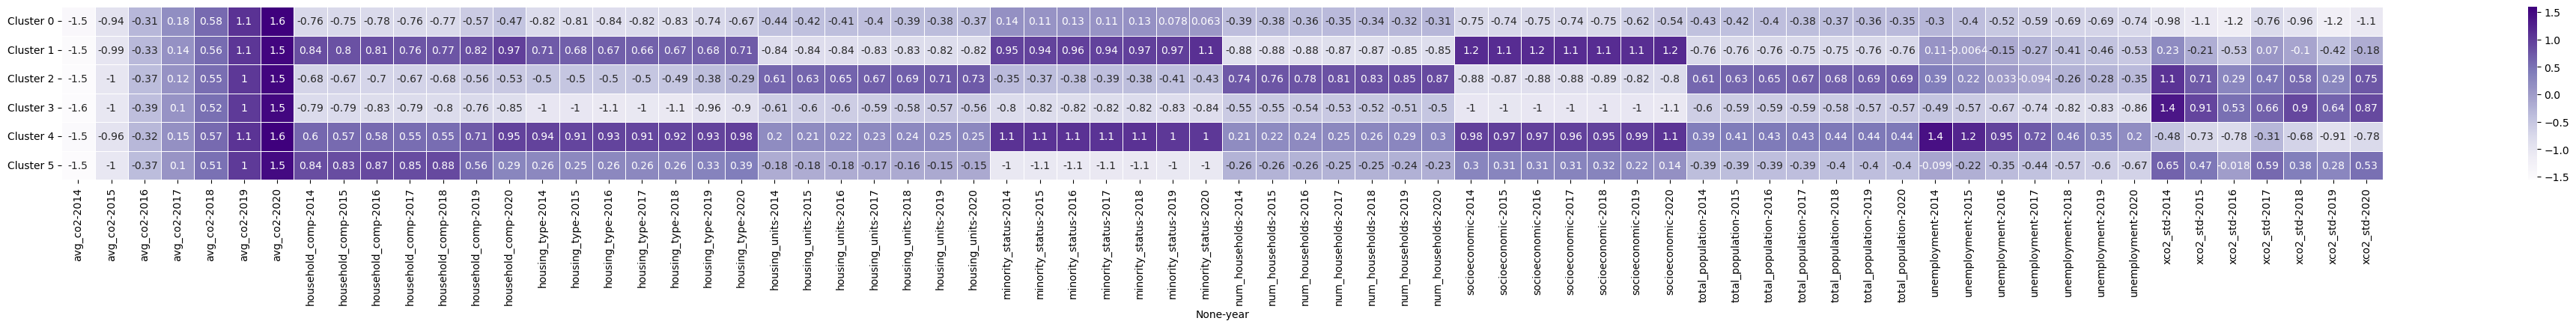

In [46]:
kmeans_pivot_centroid_sum_mean_3, kmeans_pivot_centroid_sum_median_3 = centroid_summary(0, 6, kmeans_pivot_3.labels_, pivoted_df)

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_pivot_centroid_sum_mean_3, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_pivot_centroid_sum_median_3, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

## Functional Data Reduction

We utilize functional data reduction to run the models on characteristics of the dataset such as mean and slope.

In [47]:
# Create subset of the data
fdr_subset = data[['FIPS', 'year', 'avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']].dropna(axis=0).reset_index()
fdr_subset.drop(['index'], axis=1, inplace=True)

# Scale data
# initialize scaler
scaler = StandardScaler()

scaled_fdr_subset = fdr_subset.copy()

scaled_fdr_subset[['avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']] = scaler.fit_transform(scaled_fdr_subset[['avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']])

# Create pivot using multilevel indexing
scaled_fdr_subset = scaled_fdr_subset[['FIPS', 'year', 'avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']].pivot_table(index='FIPS', columns='year')
scaled_fdr_subset.head()

avg_co2                                                            \
year           2014      2015      2016     2017      2018      2019     2020   
FIPS                                                                            
1001020100 -1.54482 -1.000387 -0.360496  0.02608  0.462927  1.011611  1.52262   
1001020200 -1.54482 -1.000387 -0.360496  0.02608  0.462927  1.011611  1.52262   
1001020300 -1.54482 -1.000387 -0.360496  0.02608  0.462927  1.011611  1.52262   
1001020400 -1.54482 -1.000387 -0.360496  0.02608  0.462927  1.011611  1.52262   
1001020500 -1.54482 -1.000387 -0.360496  0.02608  0.462927       NaN      NaN   

           household_comp                      ... unemployment            \
year                 2014      2015      2016  ...         2018      2019   
FIPS                                           ...                          
1001020100      -0.587399 -0.773455 -0.959510  ...    -1.031834 -1.106653   
1001020200      -0.575693 -0.078008  0.419677  ...    -1.031834 -1.058241   
1001020300       1.301534  0.972522  0.643511  ...    -0.855787 -0.864589   
1001020400       1.047548  1.054820  1.062092  ...    -0.908601 -0.952613   
1001020500      -0.157468 -0.234799 -0.312130  ...    -0.459683       NaN   

                      xco2_std                                          \
year            2020      2014      2015      2016      2017      2018   
FIPS                                                                     
1001020100 -1.181473 -0.313313 -0.408688 -1.850916 -0.025444 -0.158256   
1001020200 -1.084647 -0.313313 -0.408688 -1.850916 -0.025444 -0.158256   
1001020300 -0.873392 -0.313313 -0.408688 -1.850916 -0.025444 -0.158256   
1001020400 -0.996624 -0.313313 -0.408688 -1.850916 -0.025444 -0.158256   
1001020500       NaN -0.313313 -0.408688 -1.850916 -0.025444 -0.158256   

                                
year            2019      2020  
FIPS                            
1001020100 -0.999227 -0.857332  
1001020200 -0.999227 -0.857332  
1001020300 -0.999227 -0.857332  
1001020400 -0.999227 -0.857332  
1001020500       NaN       NaN  

[5 rows x 77 columns]

In [48]:
# Create placehold dataframe to hold the calculated means and slopes
columns = ['avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']
features = ['Mean','Slope']

my_column = pd.MultiIndex.from_product([features,columns],
                                     names=('features','columns'))

fdr_df = pd.DataFrame(index = scaled_fdr_subset.index,
                       columns=my_column)

fdr_df.head(5)

features      Mean                                                             \
columns    avg_co2 total_population housing_units num_households unemployment   
FIPS                                                                            
1001020100     NaN              NaN           NaN            NaN          NaN   
1001020200     NaN              NaN           NaN            NaN          NaN   
1001020300     NaN              NaN           NaN            NaN          NaN   
1001020400     NaN              NaN           NaN            NaN          NaN   
1001020500     NaN              NaN           NaN            NaN          NaN   

features                                                              \
columns    socioeconomic household_comp minority_status housing_type   
FIPS                                                                   
1001020100           NaN            NaN             NaN          NaN   
1001020200           NaN            NaN             NaN          NaN   
1001020300           NaN            NaN             NaN          NaN   
1001020400           NaN            NaN             NaN          NaN   
1001020500           NaN            NaN             NaN          NaN   

features                ...            Slope                               \
columns    overall_svi  ... total_population housing_units num_households   
FIPS                    ...                                                 
1001020100         NaN  ...              NaN           NaN            NaN   
1001020200         NaN  ...              NaN           NaN            NaN   
1001020300         NaN  ...              NaN           NaN            NaN   
1001020400         NaN  ...              NaN           NaN            NaN   
1001020500         NaN  ...              NaN           NaN            NaN   

features                                                              \
columns    unemployment socioeconomic household_comp minority_status   
FIPS                                                                   
1001020100          NaN           NaN            NaN             NaN   
1001020200          NaN           NaN            NaN             NaN   
1001020300          NaN           NaN            NaN             NaN   
1001020400          NaN           NaN            NaN             NaN   
1001020500          NaN           NaN            NaN             NaN   

features                                      
columns    housing_type overall_svi xco2_std  
FIPS                                          
1001020100          NaN         NaN      NaN  
1001020200          NaN         NaN      NaN  
1001020300          NaN         NaN      NaN  
1001020400          NaN         NaN      NaN  
1001020500          NaN         NaN      NaN  

[5 rows x 22 columns]

In [49]:
columns = ['avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']

for FIP in fdr_df.index:
    for col in columns:
        fdr_df.loc[FIP,('Mean',col)] = scaled_fdr_subset.loc[FIP,col].mean()
        fdr_df.loc[FIP,('Slope',col)] = scaled_fdr_subset.loc[FIP,col].diff().mean()

fdr_df.dropna(axis=0, inplace=True)
fdr_df.head()

features        Mean                                                \
columns      avg_co2 total_population housing_units num_households   
FIPS                                                                 
1001020100  0.016791        -1.157485     -1.316899      -1.202232   
1001020200  0.016791        -1.089423     -1.203452      -1.185033   
1001020300  0.016791        -0.449258      -0.48824      -0.455733   
1001020400  0.016791        -0.112528      0.052747       0.125859   
1001020500 -0.483339         3.018837      3.250484       3.601381   

features                                                              \
columns    unemployment socioeconomic household_comp minority_status   
FIPS                                                                   
1001020100    -1.019259     -0.306831      -0.343954        -0.45834   
1001020200    -0.703004      0.725222      -0.475812        0.514466   
1001020300    -0.785997      -0.05676       1.106331        0.268155   
1001020400    -0.269175     -0.648701       1.055478       -0.414936   
1001020500    -0.327648     -0.968032      -0.021393       -0.383599   

features                             ...            Slope                \
columns    housing_type overall_svi  ... total_population housing_units   
FIPS                                 ...                                  
1001020100    -1.224055    -0.84319  ...          0.00336     -0.000814   
1001020200     1.027806    0.711577  ...        -0.047939     -0.027468   
1001020300    -0.508808     0.19087  ...         0.032533      0.011191   
1001020400    -1.497702   -0.842346  ...        -0.060067      -0.02584   
1001020500      0.10655   -0.499368  ...        -0.122674       0.01465   

features                                                             \
columns    num_households unemployment socioeconomic household_comp   
FIPS                                                                  
1001020100       0.001147    -0.044012      0.010391       0.099088   
1001020200      -0.051365    -0.200986     -0.162767      -0.155253   
1001020300       0.032333    -0.019072     -0.085389      -0.005676   
1001020400      -0.015364    -0.250866     -0.114761       0.007035   
1001020500       0.003096    -0.180448      0.084721       0.164949   

features                                                       
columns    minority_status housing_type overall_svi  xco2_std  
FIPS                                                           
1001020100         0.04578    -0.157259   -0.037269  -0.09067  
1001020200        0.044791    -0.013334   -0.137426  -0.09067  
1001020300        0.071434    -0.005497   -0.026952  -0.09067  
1001020400       -0.104591     0.075852   -0.001449  -0.09067  
1001020500        0.077222     0.054389    0.117632  0.038764  

[5 rows x 22 columns]

### DBSCAN with functional data reduction

In [50]:
eps = np.linspace(1.0, 2.0, 5)
min_samples = list(range(5,11))
fdr_eps, fdr_samples, fdr_sil, fdr_n_clusters, fdr_dbscan_df = dbscan_test(eps, min_samples, fdr_df)

In [51]:
dbscan_fdr = pd.DataFrame(data={'Epsilon': fdr_eps, 'Min_samples': fdr_samples, 'Silhouette Scores': fdr_sil, 'Num of Clusters': fdr_n_clusters})

# Epsilon, Min_samples at max silhouette score
dbscan_fdr.loc[dbscan_fdr['Silhouette Scores'].idxmax()]

Epsilon              2.000000
Min_samples          5.000000
Silhouette Scores    0.662561
Num of Clusters      2.000000
Name: 24, dtype: float64

In [52]:
print(dbscan_fdr.to_string())

    Epsilon  Min_samples  Silhouette Scores  Num of Clusters
0      1.00            5           0.099612               28
1      1.00            6           0.141680               25
2      1.00            7           0.098847               15
3      1.00            8           0.126410               11
4      1.00            9           0.100738                7
5      1.00           10           0.132564                6
6      1.25            5           0.309914                9
7      1.25            6           0.251200                6
8      1.25            7           0.233461                6
9      1.25            8           0.216264                5
10     1.25            9           0.381438                2
11     1.25           10           0.400944                1
12     1.50            5           0.178453                5
13     1.50            6           0.291812                3
14     1.50            7           0.522601                2
15     1.50            8

Filter to see the results where the model resulted in clusters > 2 and < 10 to help select the one that could be used to interpret results of clustering. 

In [53]:
dbscan_fdr[(dbscan_fdr['Num of Clusters'] > 2) & (dbscan_fdr['Num of Clusters'] < 10)]

Epsilon  Min_samples  Silhouette Scores  Num of Clusters
4      1.00            9           0.100738                7
5      1.00           10           0.132564                6
6      1.25            5           0.309914                9
7      1.25            6           0.251200                6
8      1.25            7           0.233461                6
9      1.25            8           0.216264                5
12     1.50            5           0.178453                5
13     1.50            6           0.291812                3
15     1.50            8           0.510957                3
16     1.50            9           0.504466                3
17     1.50           10           0.501478                3

Refit DBSCAN models using epsilon = 1.50, min_sample = 8 and epsilon = 1.50, min_sample = 9

In [54]:
dbscan_fdr_fin_1, fdr_cluster_num_1, fdr_sil_score_1 = fit_dbscan(fdr_df, 1.50, 8)
dbscan_fdr_fin_2, fdr_cluster_num_2, fdr_sil_score_2 = fit_dbscan(fdr_df, 1.50, 9)

In [55]:
dbscan_fdr_fin_1['Cluster'].value_counts()

 0    71039
-1      786
 1       13
 2        6
Name: Cluster, dtype: int64

In [56]:
dbscan_fdr_fin_2['Cluster'].value_counts()

 0    71011
-1      817
 2       10
 1        6
Name: Cluster, dtype: int64

Centroid analyses of DBSCAN using functional data reduction

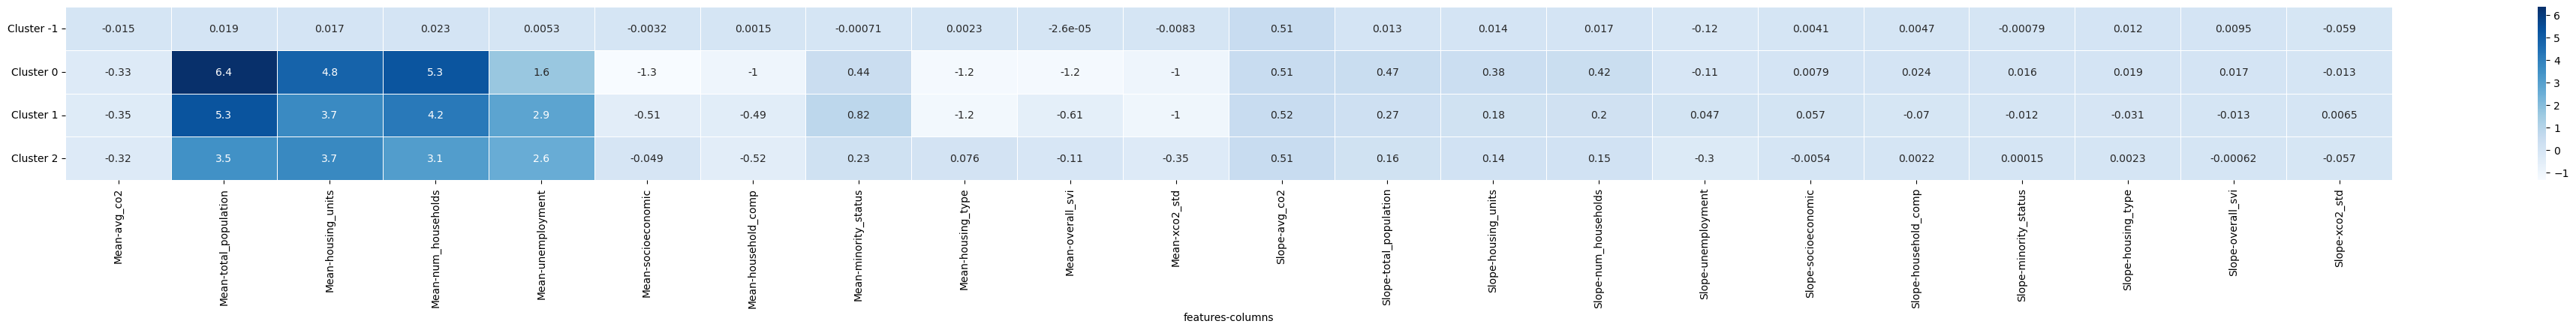

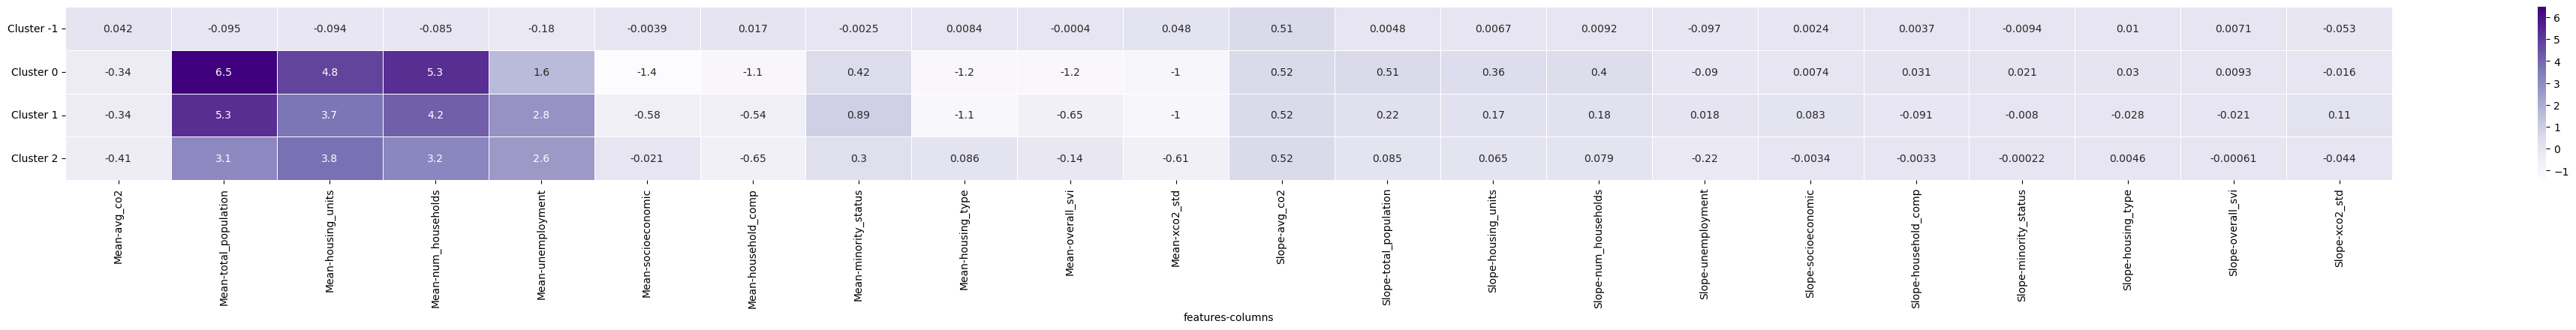

In [57]:
dbscan_fdr_centroid_sum_mean_1, dbscan_fdr_centroid_sum_median_1 = centroid_summary(-1, 3, dbscan_fdr_fin_1['Cluster'], fdr_df)

plt.figure(figsize=(50,3))
sns.heatmap(dbscan_fdr_centroid_sum_mean_1, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(50,3))
sns.heatmap(dbscan_fdr_centroid_sum_median_1, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

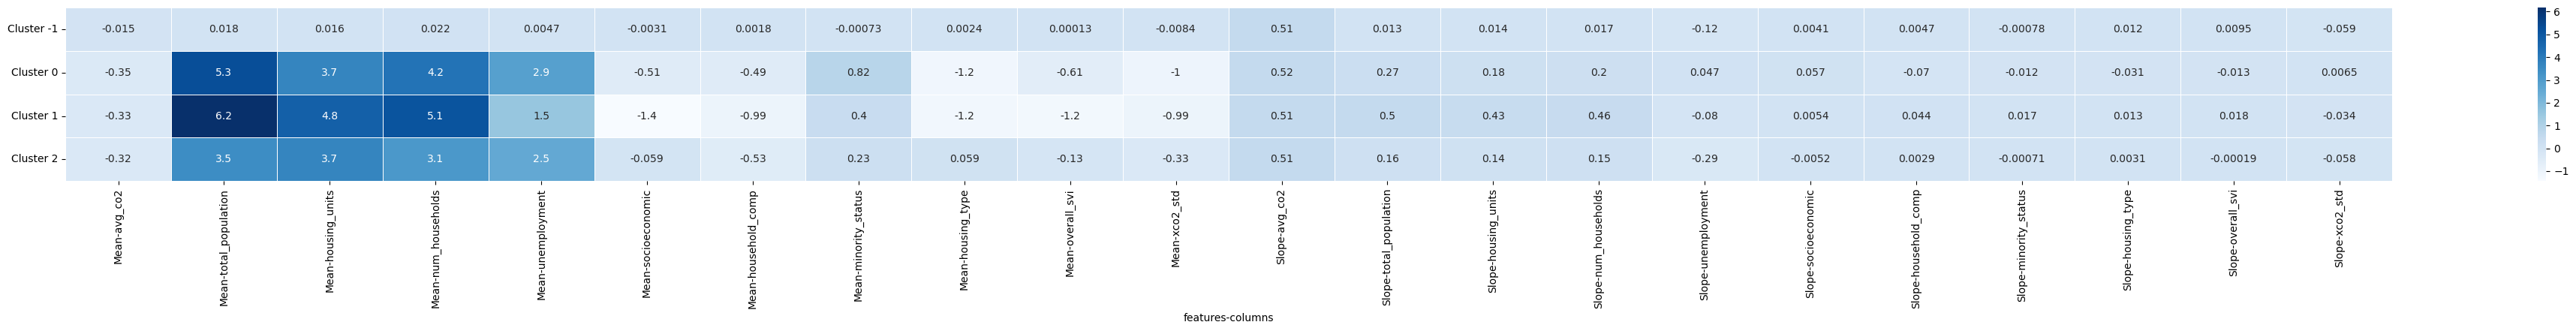

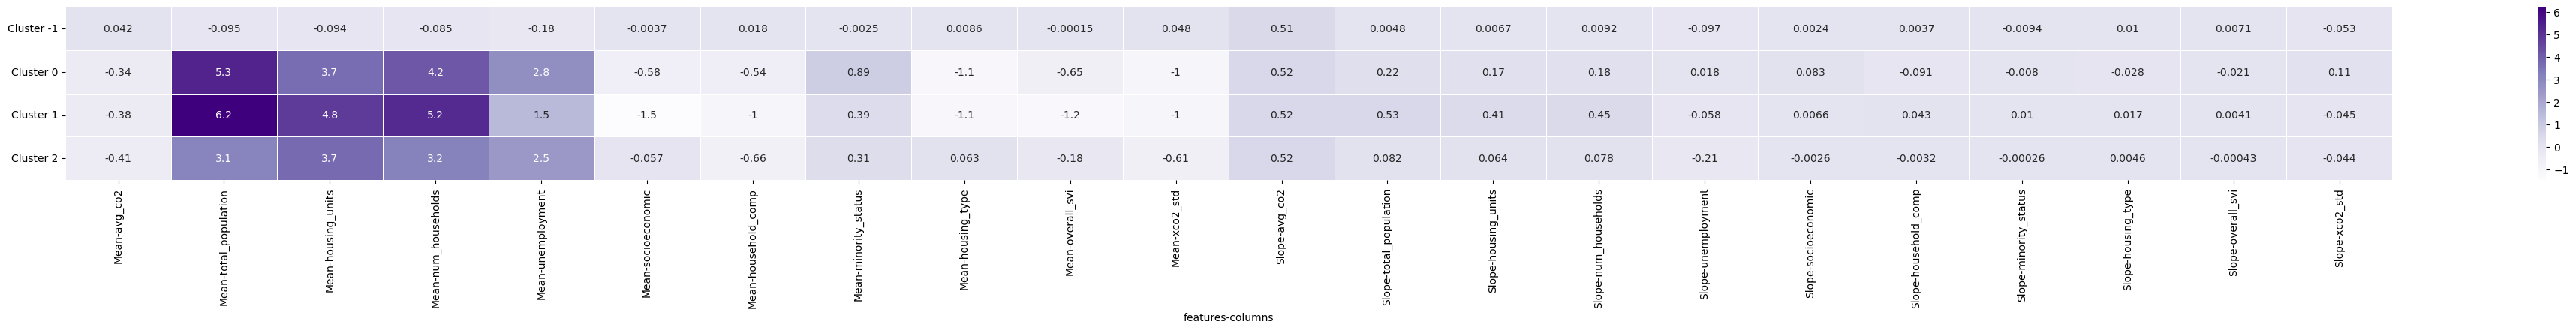

In [58]:
dbscan_fdr_centroid_sum_mean_2, dbscan_fdr_centroid_sum_median_2 = centroid_summary(-1, 3, dbscan_fdr_fin_2['Cluster'], fdr_df)

plt.figure(figsize=(50,3))
sns.heatmap(dbscan_fdr_centroid_sum_mean_2, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(50,3))
sns.heatmap(dbscan_fdr_centroid_sum_median_2, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

### Kmeans with functional data reduction

In [59]:
# Sample of dataset to run SSE and silhouette score to select kmeans num of clusters
fdr_df_sample = fdr_df.sample(30000)

/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

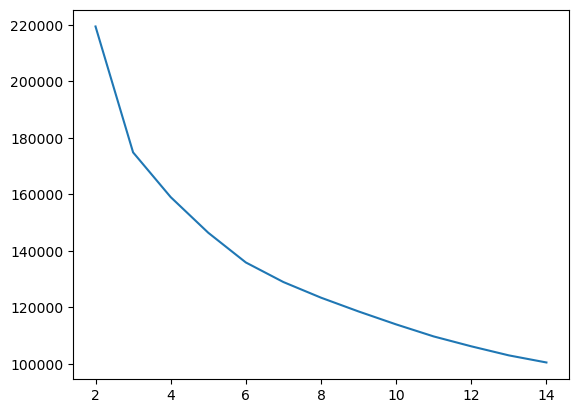

In [60]:
sse_fdr_results = kmeans_sse(fdr_df_sample)
(sse_fdr_results.Mean).plot()
plt.show()

/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

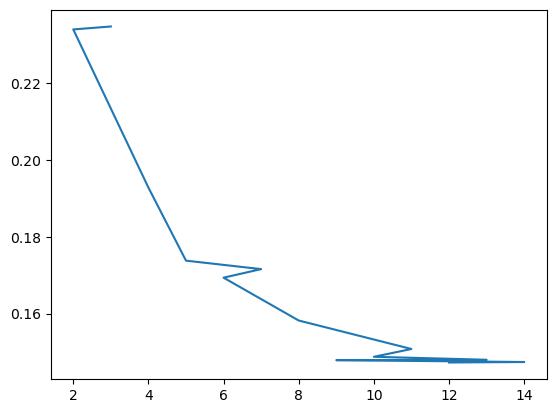

In [61]:
sil_fdr_results = kmeans_sil_scores(fdr_df_sample)
(sil_fdr_results.Mean).plot()
plt.show()

In [62]:
# Fit kmeans model for n_clusters = 4, n_clusters = 5, n_clusters = 6 on full dataset
kmeans_fdr_1 = KMeans(n_clusters=4).fit(fdr_df)
kmeans_fdr_2 = KMeans(n_clusters=5).fit(fdr_df)
kmeans_fdr_3 = KMeans(n_clusters=6).fit(fdr_df)

/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/nhu-ypham/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [63]:
# Calculate silhouette score of each model
kmeans_fdr_sil1, kmeans_fdr_clust_cnt_1 = silhouette_score(fdr_df, kmeans_fdr_1.labels_)
print('Silhouette score of kmeans model with n_clusters = 4: ' + str(kmeans_fdr_sil1))

kmeans_fdr_sil2, kmeans_fdr_clust_cnt_2 = silhouette_score(fdr_df, kmeans_fdr_2.labels_)
print('Silhouette score of kmeans model with n_clusters = 5: ' + str(kmeans_fdr_sil2))

kmeans_fdr_sil3, kmeans_fdr_clust_cnt_3 = silhouette_score(fdr_df, kmeans_fdr_3.labels_)
print('Silhouette score of kmeans model with n_clusters = 6: ' + str(kmeans_fdr_sil3))

Silhouette score of kmeans model with n_clusters = 4: 0.26678323991334296
Silhouette score of kmeans model with n_clusters = 5: 0.2606733904219389
Silhouette score of kmeans model with n_clusters = 6: 0.30872465589716586


In [64]:
# Count of points assigned to each cluster

# Kmeans, n_cluster = 4
kmeans_fdr_clust_cnt_1

1    26373
0    19996
3    14661
2    10814
Name: Cluster, dtype: int64

In [65]:
# Kmeans, n_cluster = 5
kmeans_fdr_clust_cnt_2

4    20158
0    18926
1    16943
2    12844
3     2973
Name: Cluster, dtype: int64

In [66]:
# Kmeans, n_cluster = 6
kmeans_fdr_clust_cnt_3

0    15680
2    15075
4    13736
5    13678
3    11464
1     2211
Name: Cluster, dtype: int64

Centroid analyses of Kmeans using functional data reduction

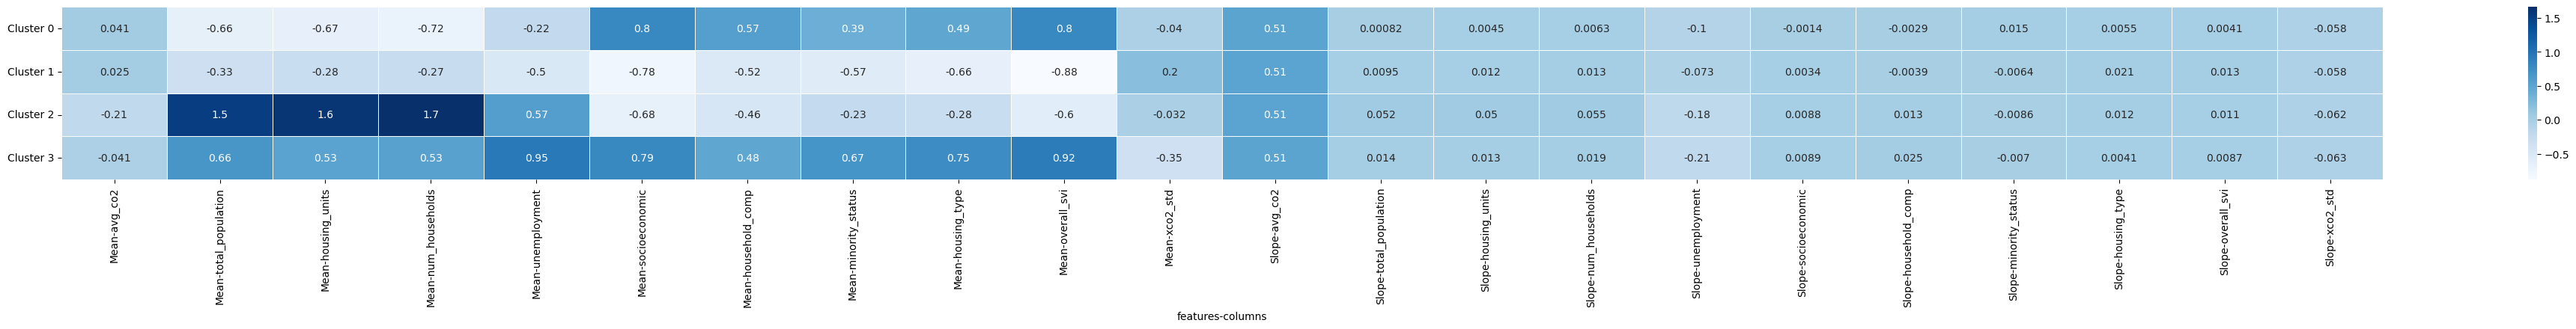

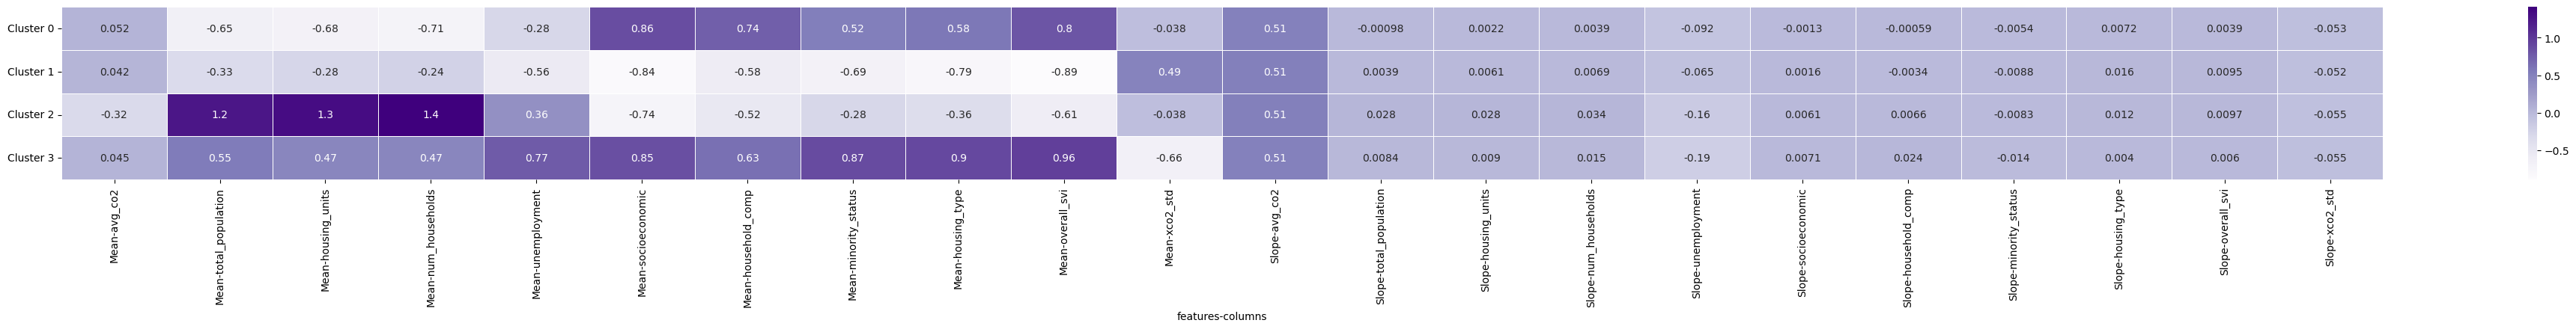

In [67]:
kmeans_fdr_centroid_sum_mean_1, kmeans_fdr_centroid_sum_median_1 = centroid_summary(0, 4, kmeans_fdr_1.labels_, fdr_df)

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_fdr_centroid_sum_mean_1, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_fdr_centroid_sum_median_1, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

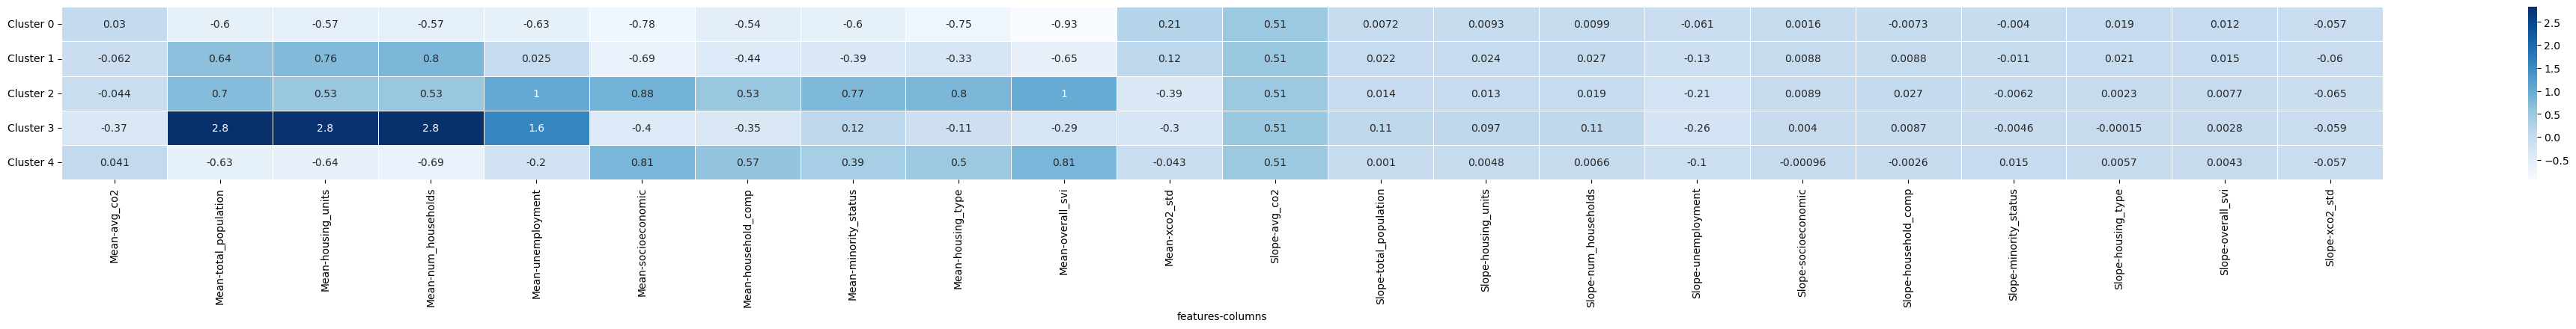

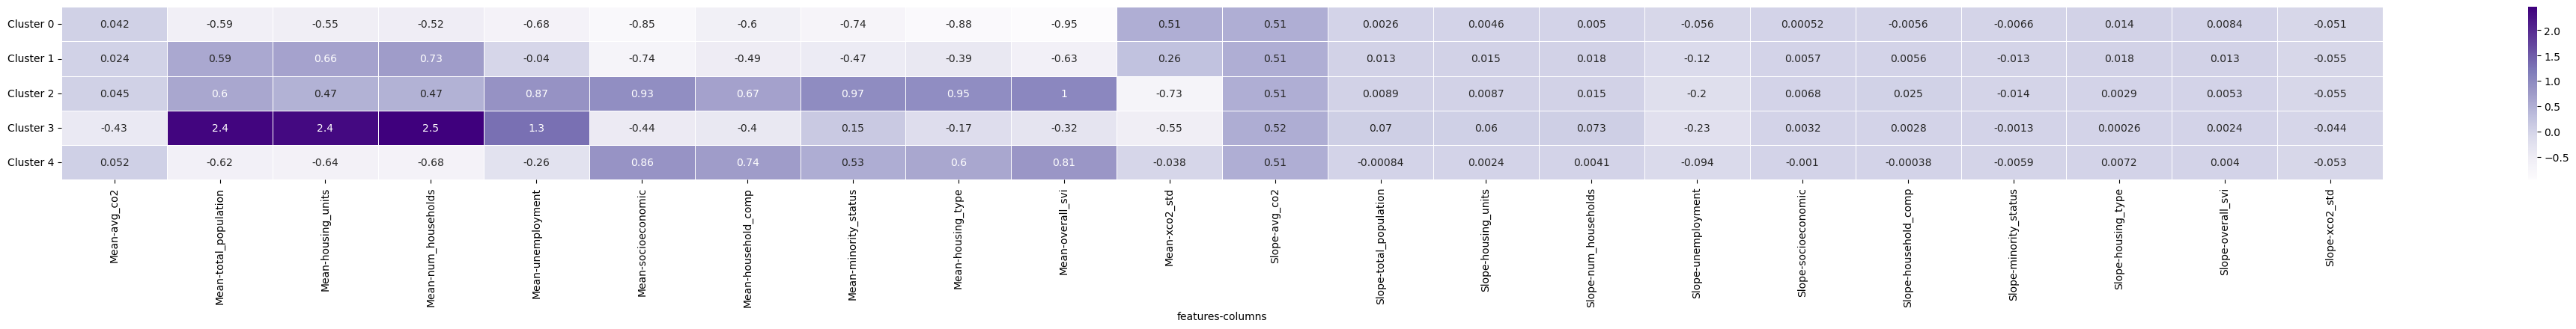

In [68]:
kmeans_fdr_centroid_sum_mean_2, kmeans_fdr_centroid_sum_median_2 = centroid_summary(0, 5, kmeans_fdr_2.labels_, fdr_df)

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_fdr_centroid_sum_mean_2, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_fdr_centroid_sum_median_2, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

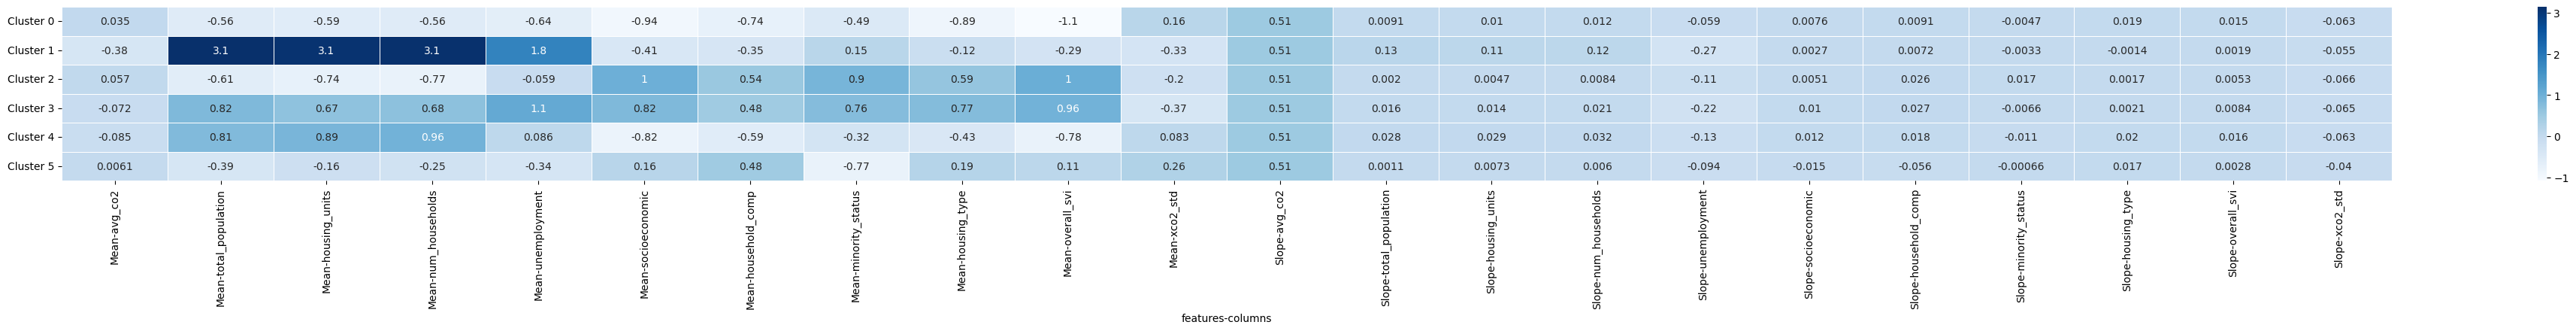

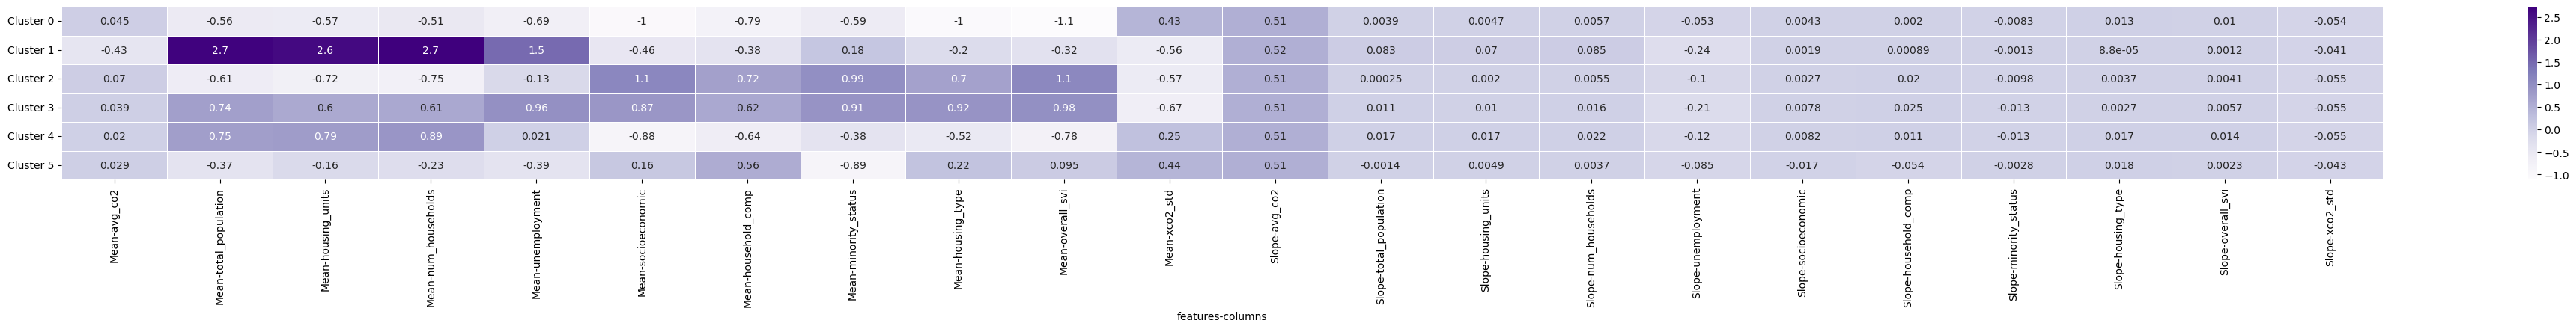

In [69]:
kmeans_fdr_centroid_sum_mean_3, kmeans_fdr_centroid_sum_median_3 = centroid_summary(0, 6, kmeans_fdr_3.labels_, fdr_df)

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_fdr_centroid_sum_mean_3, linewidths=.5, annot=True, 
                    cmap='Blues')
plt.show()

plt.figure(figsize=(50,3))
sns.heatmap(kmeans_fdr_centroid_sum_median_3, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

## Calculating Davies-Boudin Scoring for models with highest silhouette scores

In [75]:
from sklearn.metrics import davies_bouldin_score

# Davies-Boudin score for total percentage change in CO2 models
dbscan_tot_pct_dbscore = davies_bouldin_score(dbscan_tot_pct_change_fin_1, dbscan_tot_pct_change_fin_1['Cluster'])
print('DBSCAN Davies-Bouldin score for total percentage change in CO2 cluster model: ' + str(dbscan_tot_pct_dbscore))
kmeans_tot_pct_dbscore = davies_bouldin_score(scaled_df_tot_pct_change, kmeans_tot_pct_2.labels_)
print('K-means Davies-Bouldin score for total percentage change in CO2 cluster model: ' + str(kmeans_tot_pct_dbscore))

DBSCAN Davies-Bouldin score for total percentage change in CO2 cluster model: 1.7357809501993222
K-means Davies-Bouldin score for total percentage change in CO2 cluster model: 1.827901915961716


In [72]:
# Davies-Boudin score for multilevel index pivot models
dbscan_pivot_dbscore = davies_bouldin_score(dbscan_pivot_fin_2, dbscan_pivot_fin_2['Cluster'])
print('DBSCAN Davies-Bouldin score for multilevel indexing across years: ' + str(dbscan_pivot_dbscore))
kmeans_pivot_dbscore = davies_bouldin_score(pivoted_df, kmeans_pivot_3.labels_)
print('K-means Davies-Bouldin score for multilevel indexing across years: ' + str(kmeans_pivot_dbscore))

DBSCAN Davies-Bouldin score for multilevel indexing across years: 1.1119438705914542
K-means Davies-Bouldin score for multilevel indexing across years: 1.7513200785671834


In [74]:
# Davies-Boudin score for functional data reduction models
dbscan_fdr_dbscore = davies_bouldin_score(dbscan_fdr_fin_1, dbscan_fdr_fin_1['Cluster'])
print('DBSCAN Davies-Bouldin score for functional data reduction: ' + str(dbscan_fdr_dbscore))
kmeans_fdr_dbscore = davies_bouldin_score(fdr_df, kmeans_fdr_3.labels_)
print('K-means Davies-Bouldin score for functional data reduction: ' + str(kmeans_fdr_dbscore))

DBSCAN Davies-Bouldin score for functional data reduction: 1.4380177134293723
K-means Davies-Bouldin score for functional data reduction: 1.5145628780940266
